In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from imblearn.over_sampling import BorderlineSMOTE

In [2]:
dataset_path = 'magic_dataset/magic04.csv'

columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'label']
df=pd.read_csv(dataset_path, names=columns, header=None)

In [3]:
def prepare_data(df, outlier, param_outlier, scale):
    """
    Thif function is used to prepare the dataset
    
    @param 
             df: pandas dataframe containing the training dataset
    @param
        outlier: Boolen for removing or not the data
    @param
        param_outlier: n_neighbors for the outlier
    @param
        scale: to scale the training dataset or not 
    
    @return
        X_train, X_test, y_train, y_test
        skf: the stratified kfold
    """
    
    #Do you want to use outlier removal?
    if outlier:
        local_outlier = LocalOutlierFactor(param_outlier)
        mask = local_outlier.fit_predict(df.iloc[:,:-1])
        mask = mask==1
        df = df[mask].copy()

    df = df.drop('fConc1', axis=1)

    X = df.drop(['label'], axis=1).copy()
    y = df.label.copy()
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, shuffle=True, stratify=y) # stratify version

    #Do you want to use the scaler?
    if scale:
        scaler = RobustScaler()
        fitted_scaler = scaler.fit(X=X_train)
        X_train = fitted_scaler.transform(X_train)
        X_test = fitted_scaler.transform(X_test)

    skf = StratifiedKFold(n_splits=11, shuffle=True, random_state=42)
    skf.get_n_splits(X_train, y_train)

    return X_train, X_test, y_train, y_test, skf

In [4]:
def evaluate_model(X, y, model, model_name, params, skf, type_sampling):
    """
    This function is used to evaluate the model and print the results.
    It uses the imbpipeline and the SMOTE technique for oversampling.
    @param
        X, y: the training data and the test data (X_train, X_test), (y_train, y_test)
    @param
        model: the model to be evaluated
    @param
        model_name: useful for printing
    @param
        params: parameters to be passed in the random grid search
    @param
        skf: stratified cross validation
    @param
        type_sampling: could be SMOTE, BorderlineSMOTE
    
    """
    X_train, X_test = X
    y_train, y_test = y

    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    
    if type_sampling=='SMOTE':
        pipeline = imbpipeline(steps = [['smote', SMOTE()],
                                    ['classifier', model]])

    if type_sampling=='BorderlineSMOTE':
        pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE()],
                                    ['classifier', model]])


    random_grid = RandomizedSearchCV(estimator=pipeline,
                                     scoring='f1',
                                     param_distributions=params, 
                                     cv=skf,
                                     refit=True)

    results = random_grid.fit(X_train, y_train)

    print(f"best Score {model_name} = {results.best_score_}")
    print(f"best parameter {model_name} = {results.best_params_}") 

    #report = classification_report(y_test, results.predict(X_test))
    
    #print()
    #print(report)
    print()

    fig, axes = plt.subplots( 1, 2, figsize=(25,7))

    fig.suptitle(f"{model_name}")

    axes[0].grid(False)
    axes[0].set_title("Confusion Matrix")
    plot_confusion_matrix(results.best_estimator_, X_test, y_test, ax=axes[0],
                                display_labels=['gamma', 'hadron'],
                                cmap=plt.cm.Blues,
                                normalize='true')

    axes[1].set_title("Roc Curve")
    plot_roc_curve(results.best_estimator_, X_test, y_test, ax=axes[1])

    plt.show()

# Random Forest with BorderLine Smote


In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_jobs=-1, random_state=10)

param_random_forest = { 'smote__sampling_strategy':["minority", 'all'],
                        'smote__k_neighbors': [5,7,8,10],
                        'classifier__n_estimators': [200, 101, 151],
                        'classifier__criterion': ['gini', 'entropy'],
                        'classifier__max_depth': [ 10, 15, 20, 25, 30 , 35]
                        }

outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'Random Forest, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, random_forest, title, param_random_forest, skf, 'BorderlineSMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'Random Forest, outlier {o}, scale {s}'
            evaluate_model(X, y, random_forest, title, param_random_forest, skf, 'BorderlineSMOTE')
            print()


# Random Forest with SMOTE

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 2, scale True = 0.8119114379552272
best parameter Random Forest, outlier True, param 2, scale True = {'classifier__n_estimators': 201, 'classifier__max_depth': 45, 'classifier__criterion': 'entropy'}



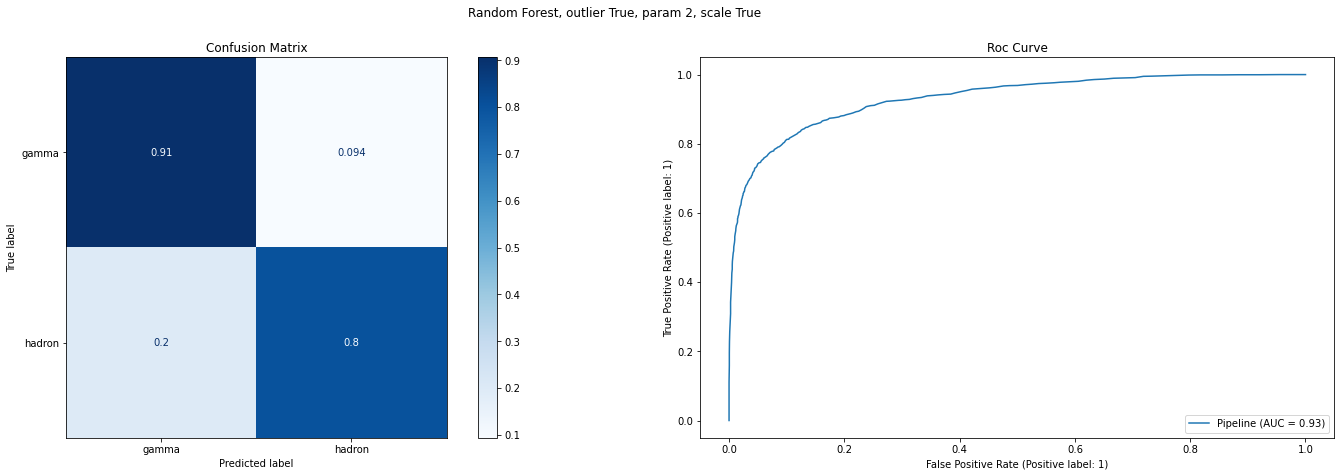


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 3, scale True = 0.815820440889103
best parameter Random Forest, outlier True, param 3, scale True = {'classifier__n_estimators': 151, 'classifier__max_depth': 35, 'classifier__criterion': 'gini'}



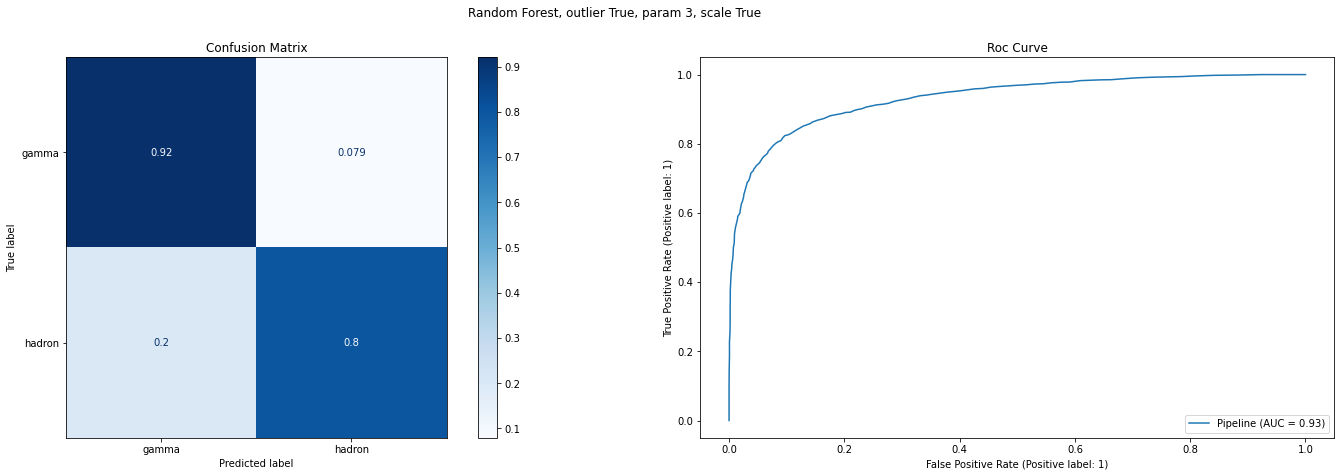


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 5, scale True = 0.8133676700221241
best parameter Random Forest, outlier True, param 5, scale True = {'classifier__n_estimators': 201, 'classifier__max_depth': 55, 'classifier__criterion': 'gini'}



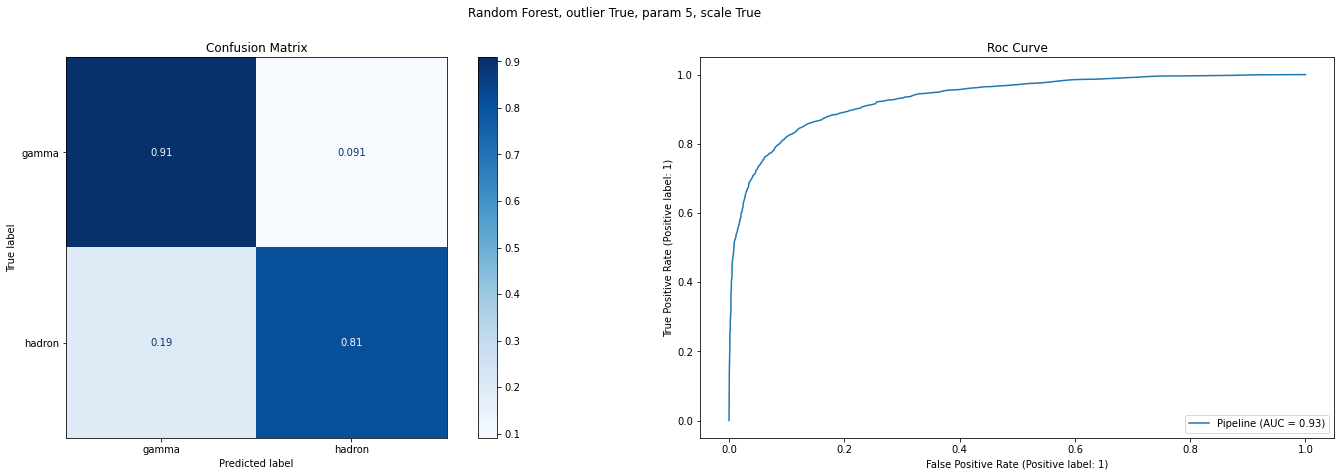


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 10, scale True = 0.8133125050533543
best parameter Random Forest, outlier True, param 10, scale True = {'classifier__n_estimators': 101, 'classifier__max_depth': 40, 'classifier__criterion': 'gini'}



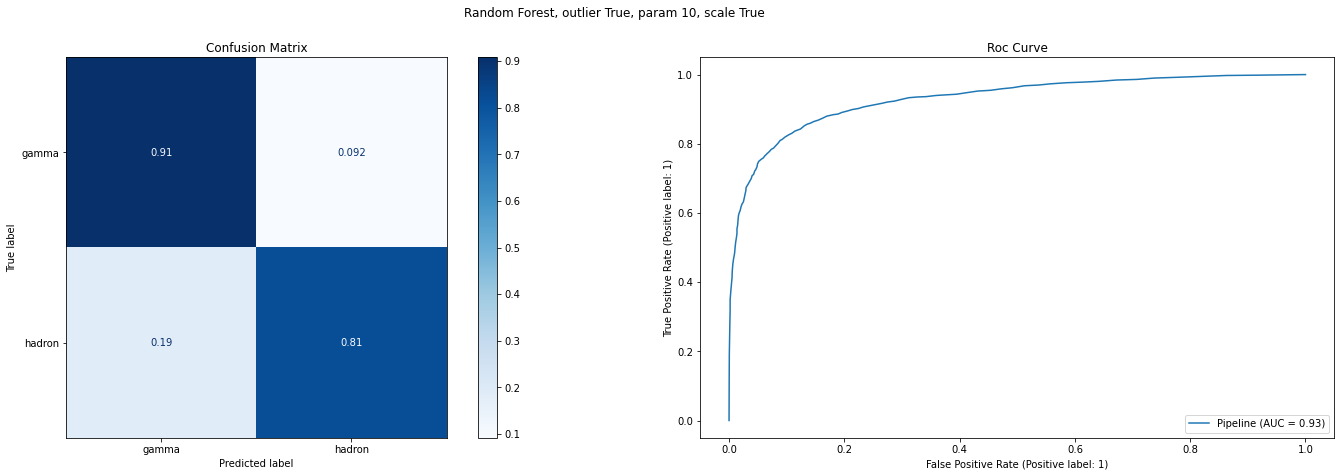


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 15, scale True = 0.8117288208213044
best parameter Random Forest, outlier True, param 15, scale True = {'classifier__n_estimators': 201, 'classifier__max_depth': 35, 'classifier__criterion': 'entropy'}



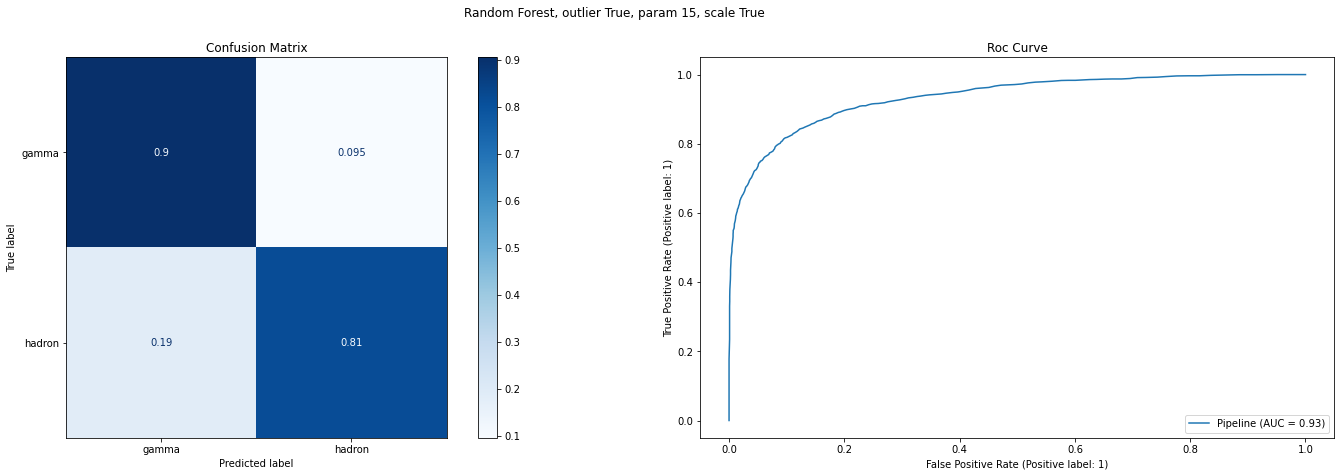


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 20, scale True = 0.8119842630936008
best parameter Random Forest, outlier True, param 20, scale True = {'classifier__n_estimators': 151, 'classifier__max_depth': 55, 'classifier__criterion': 'gini'}



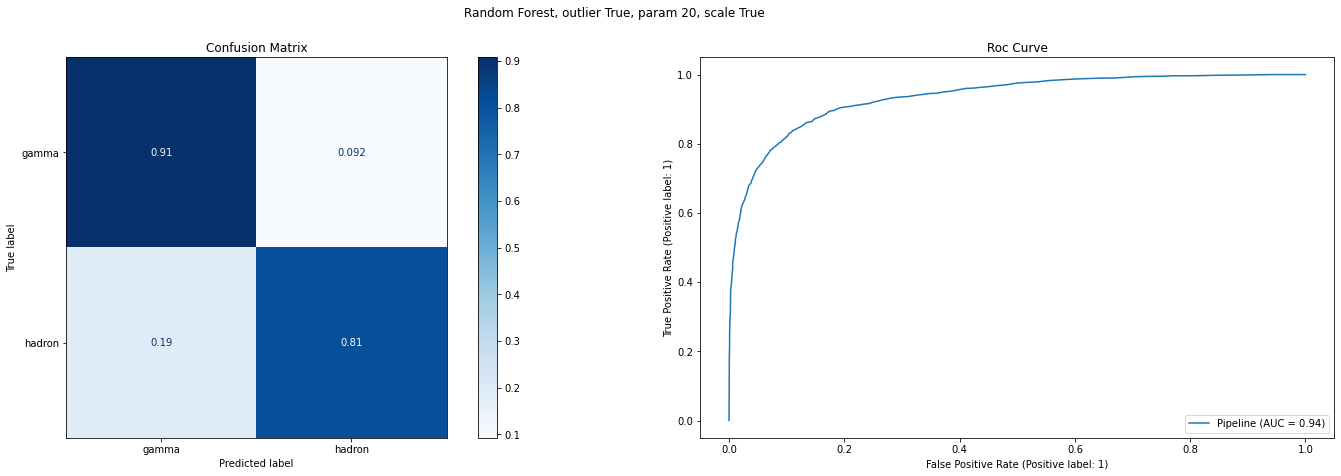


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 30, scale True = 0.8120031825272995
best parameter Random Forest, outlier True, param 30, scale True = {'classifier__n_estimators': 151, 'classifier__max_depth': 55, 'classifier__criterion': 'entropy'}



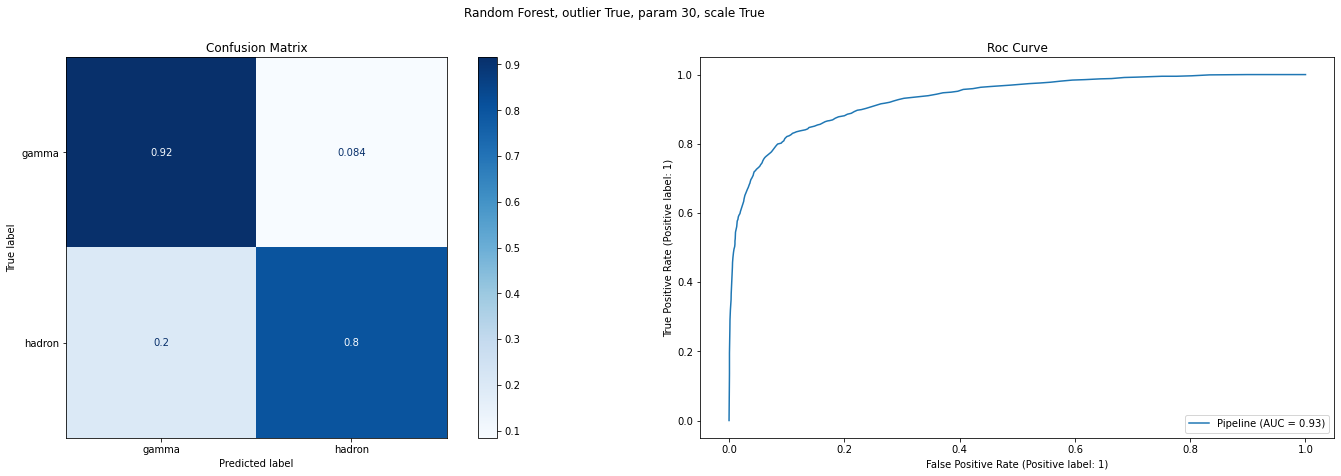


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier False, scale True = 0.8164073631403297
best parameter Random Forest, outlier False, scale True = {'classifier__n_estimators': 201, 'classifier__max_depth': 35, 'classifier__criterion': 'entropy'}



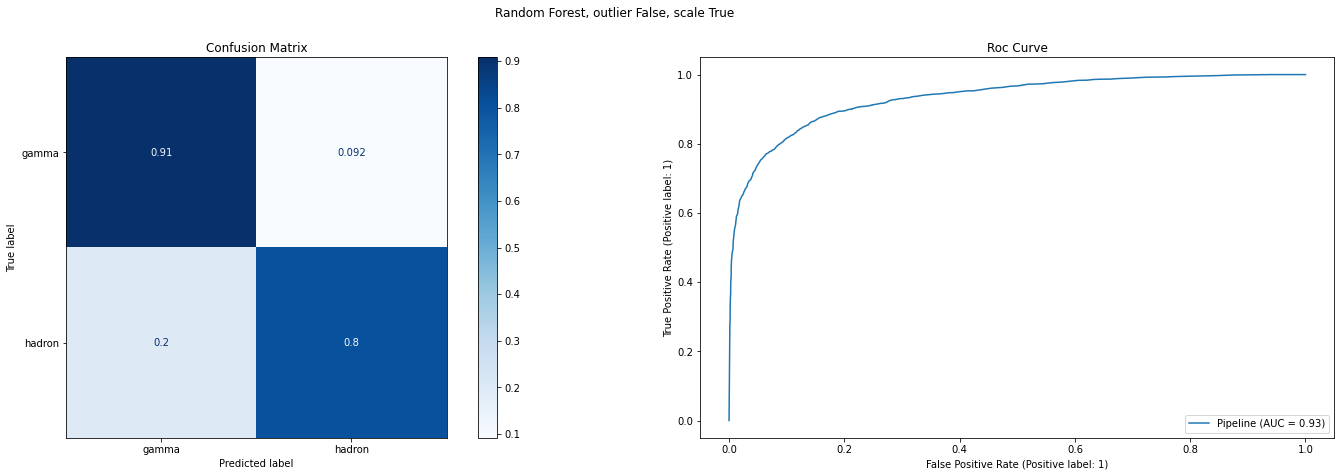


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 2, scale False = 0.8120794096206144
best parameter Random Forest, outlier True, param 2, scale False = {'classifier__n_estimators': 101, 'classifier__max_depth': 55, 'classifier__criterion': 'entropy'}



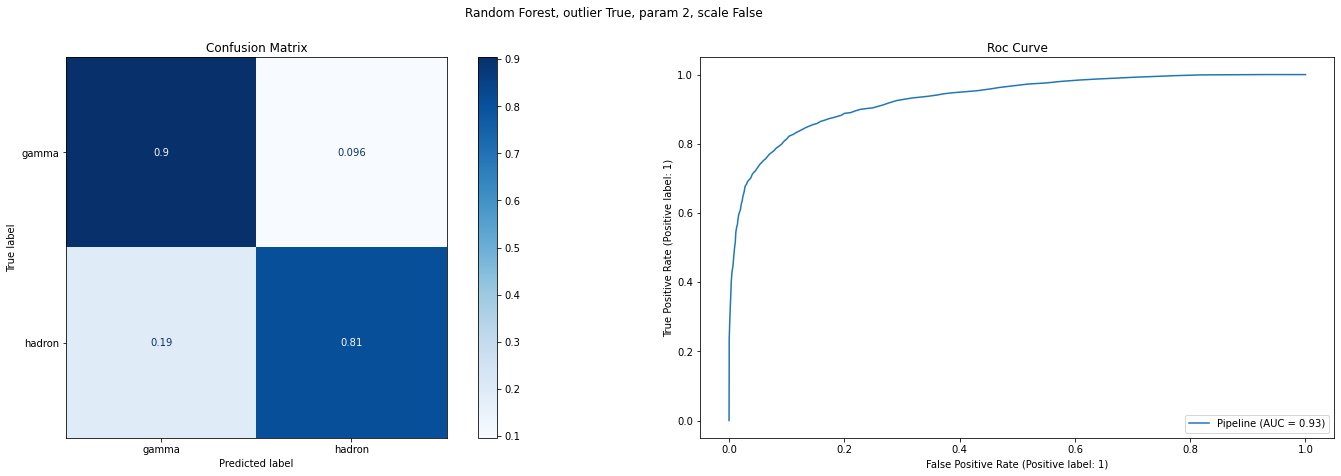


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 3, scale False = 0.8141204083058315
best parameter Random Forest, outlier True, param 3, scale False = {'classifier__n_estimators': 151, 'classifier__max_depth': 55, 'classifier__criterion': 'gini'}



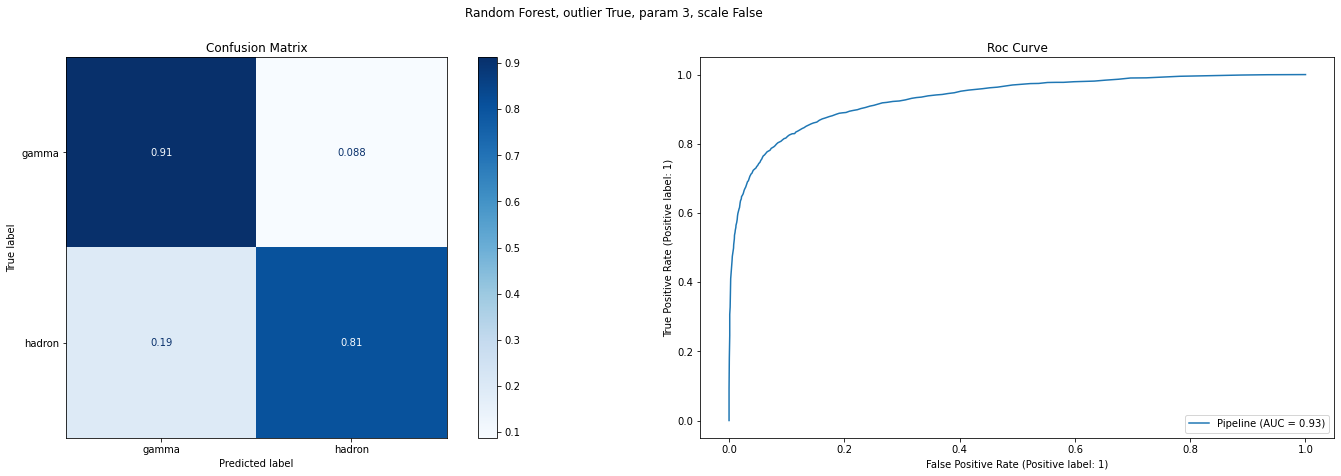


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 5, scale False = 0.8147996992420942
best parameter Random Forest, outlier True, param 5, scale False = {'classifier__n_estimators': 151, 'classifier__max_depth': 45, 'classifier__criterion': 'gini'}



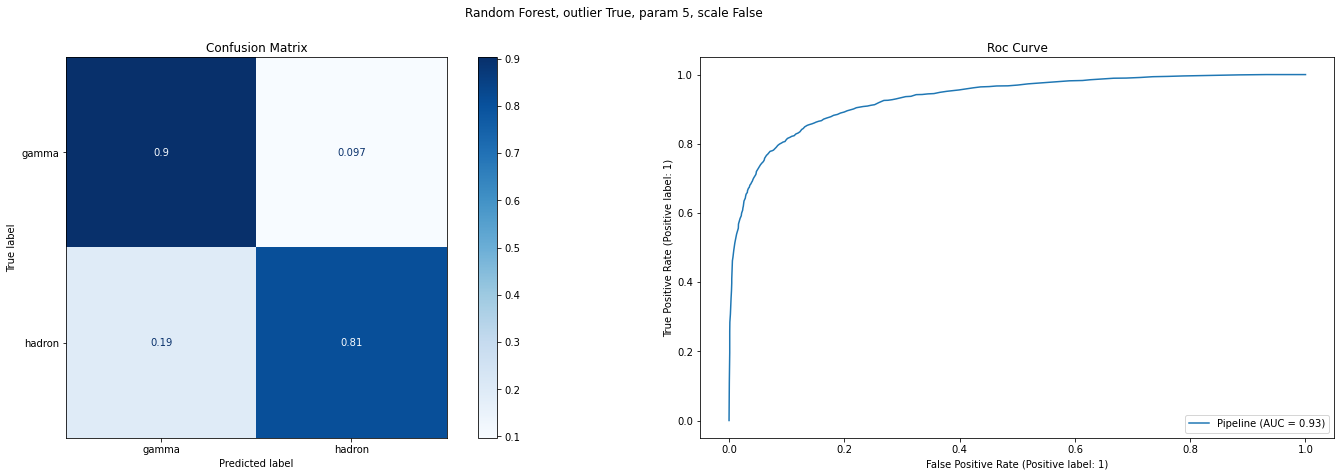


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 10, scale False = 0.8129208878852694
best parameter Random Forest, outlier True, param 10, scale False = {'classifier__n_estimators': 151, 'classifier__max_depth': 35, 'classifier__criterion': 'entropy'}



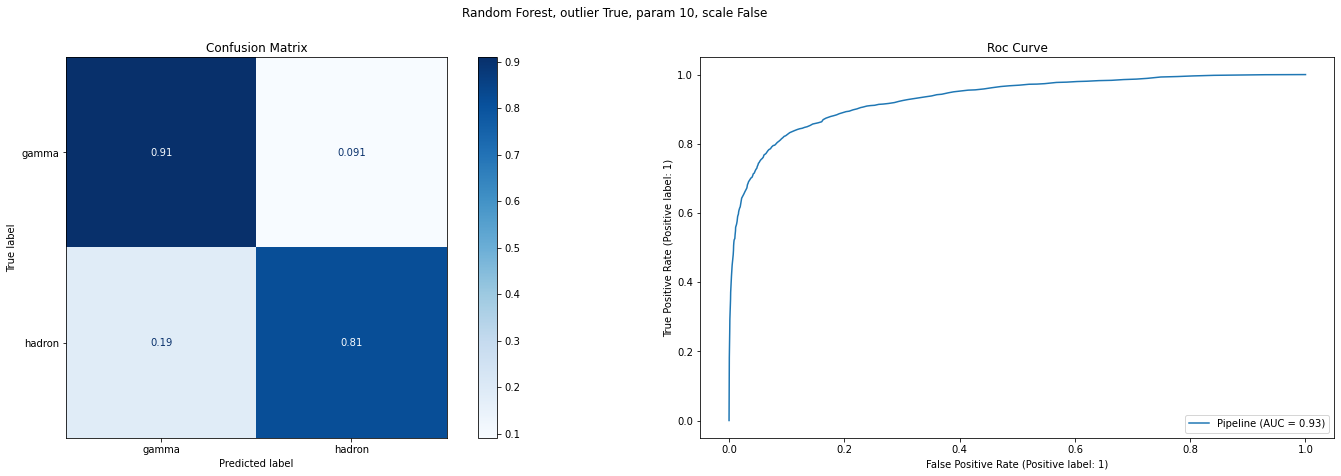


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 15, scale False = 0.8110823804029266
best parameter Random Forest, outlier True, param 15, scale False = {'classifier__n_estimators': 101, 'classifier__max_depth': 55, 'classifier__criterion': 'gini'}



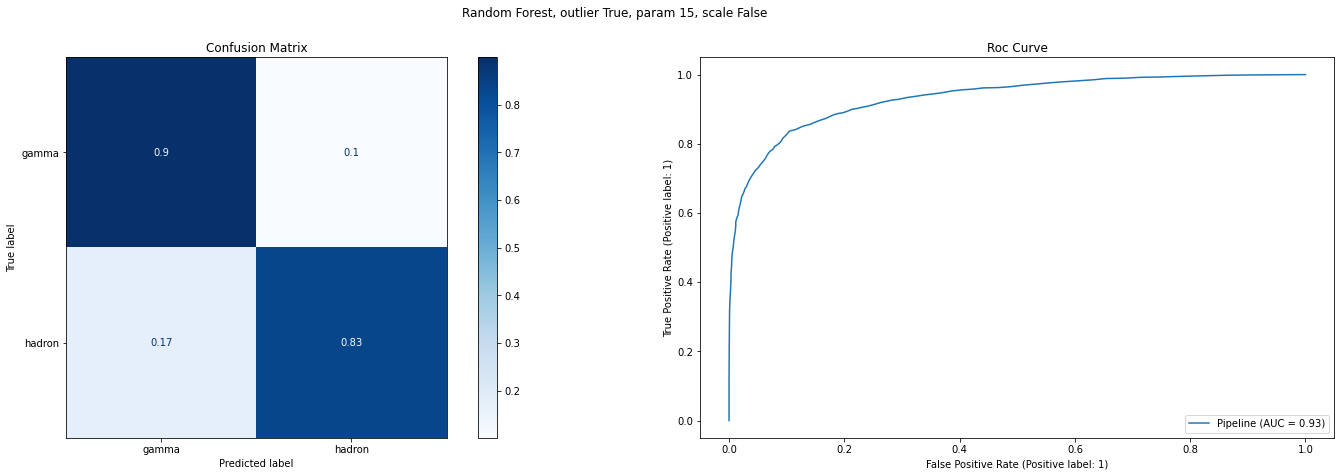


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 20, scale False = 0.8120913353017764
best parameter Random Forest, outlier True, param 20, scale False = {'classifier__n_estimators': 151, 'classifier__max_depth': 35, 'classifier__criterion': 'gini'}



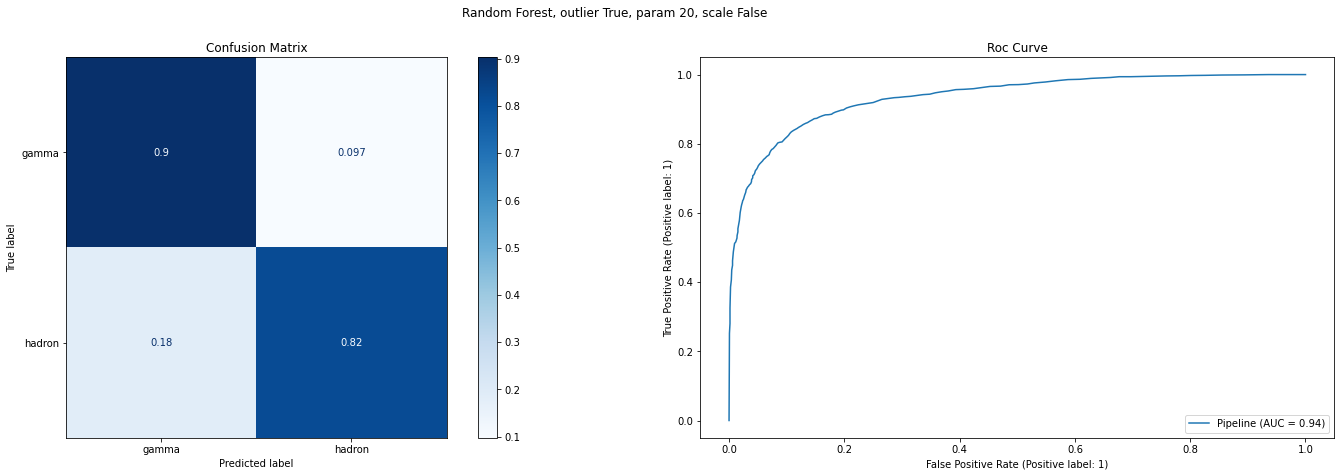


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier True, param 30, scale False = 0.8115435206312319
best parameter Random Forest, outlier True, param 30, scale False = {'classifier__n_estimators': 101, 'classifier__max_depth': 50, 'classifier__criterion': 'gini'}



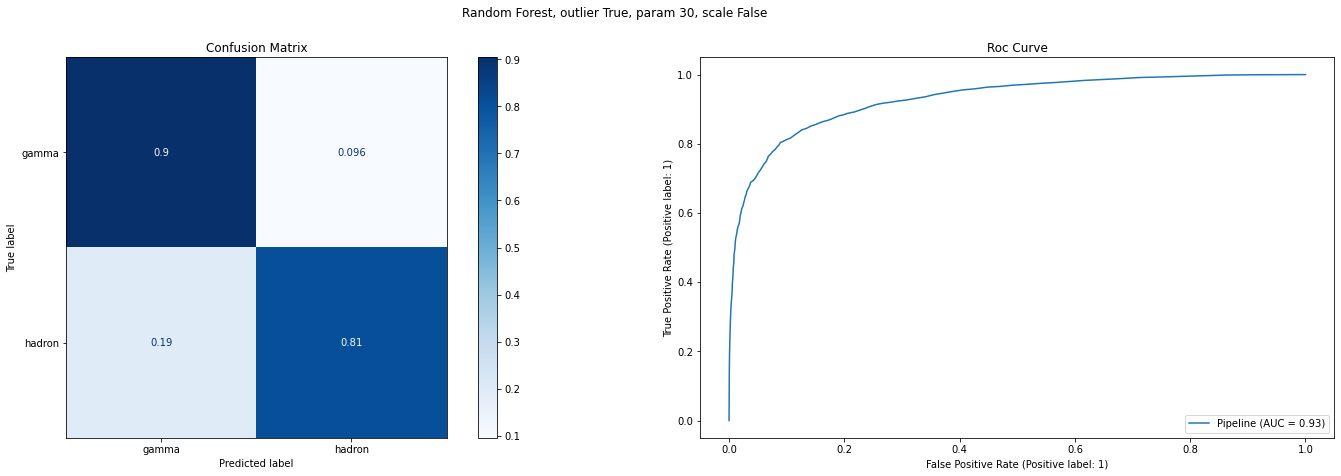


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Random Forest, outlier False, scale False = 0.8181508804129556
best parameter Random Forest, outlier False, scale False = {'classifier__n_estimators': 201, 'classifier__max_depth': 30, 'classifier__criterion': 'gini'}



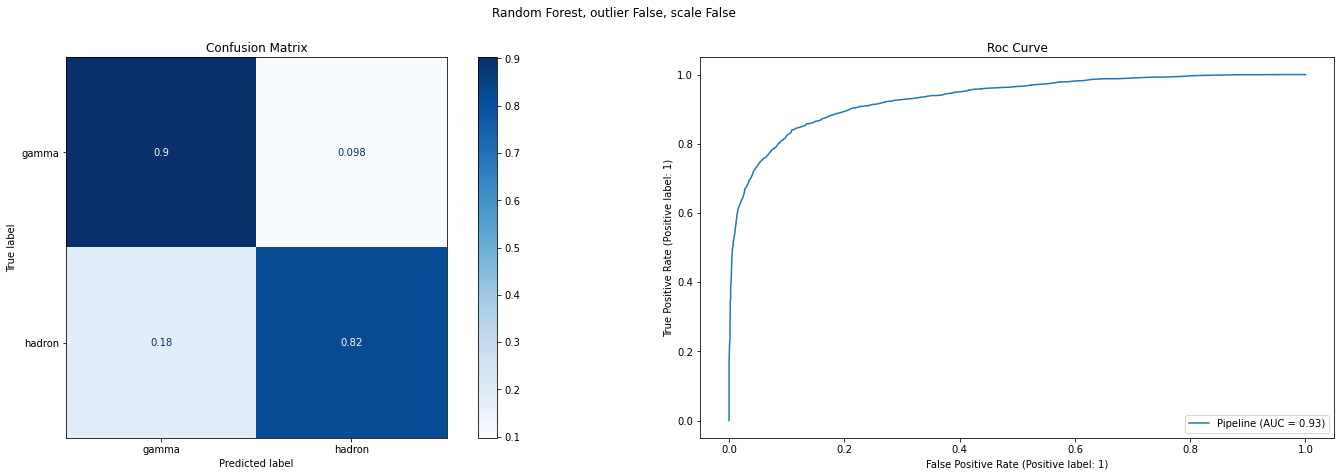

In [6]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_jobs=-1, random_state=10)

param_random_forest = { 'classifier__n_estimators': [201, 101, 151],
                        'classifier__criterion': ['gini', 'entropy'],
                        'classifier__max_depth': [ 30 , 35, 40, 45, 50, 55]
                        }

outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'Random Forest, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, random_forest, title, param_random_forest, skf, 'SMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'Random Forest, outlier {o}, scale {s}'
            evaluate_model(X, y, random_forest, title, param_random_forest, skf, 'SMOTE')
            print()

# Logistic Regression with BorderLine SMOTE

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 2, scale True = 0.703399971714907
best parameter Logistic Regression, outlier True, param 2, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 10, 'classifier__penalty': 'l1', 'classifier__C': 0.05}



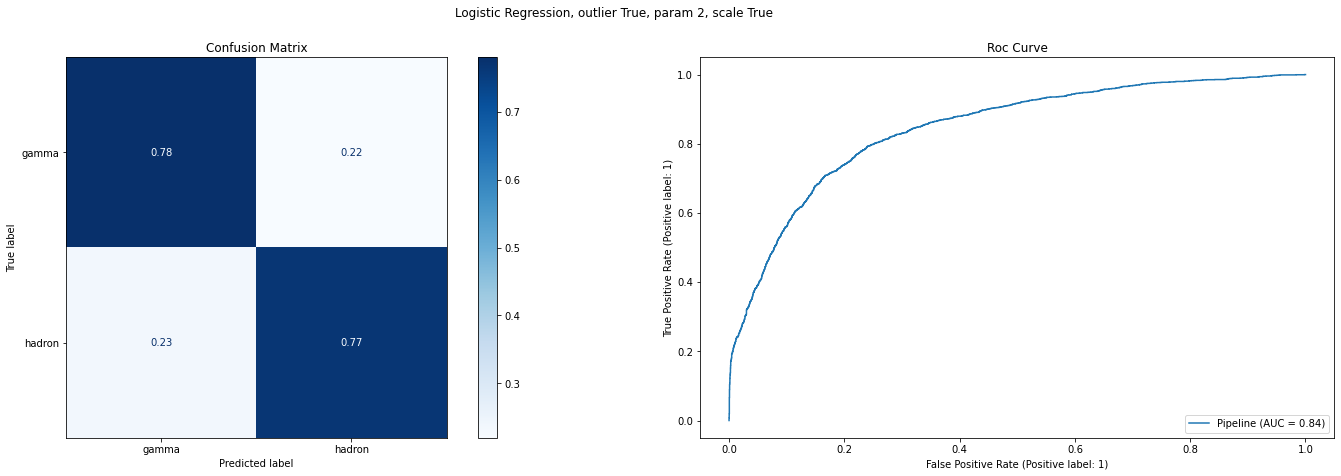


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 3, scale True = 0.7081523415261457
best parameter Logistic Regression, outlier True, param 3, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 8, 'classifier__penalty': 'l1', 'classifier__C': 0.02}



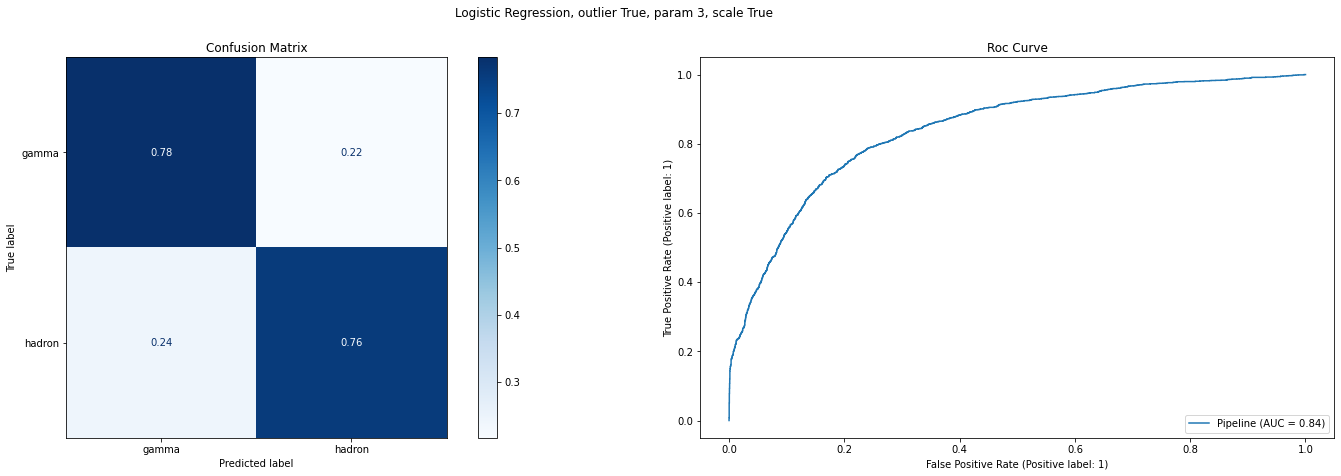


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 5, scale True = 0.7029879069335891
best parameter Logistic Regression, outlier True, param 5, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 10, 'classifier__penalty': 'l1', 'classifier__C': 0.05}



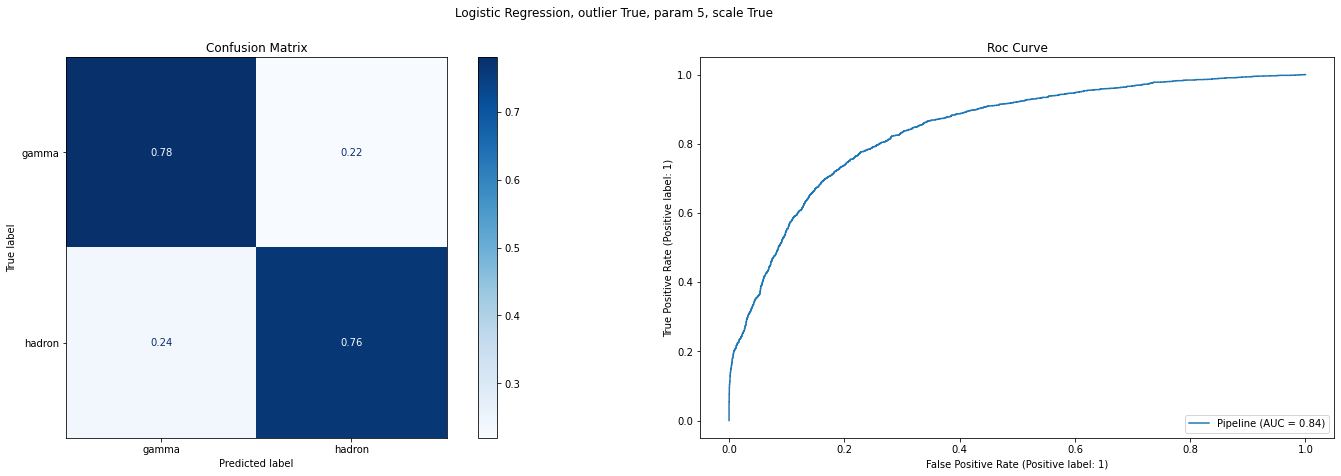


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 10, scale True = 0.6976754668864353
best parameter Logistic Regression, outlier True, param 10, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 10, 'classifier__penalty': 'l2', 'classifier__C': 0.02}



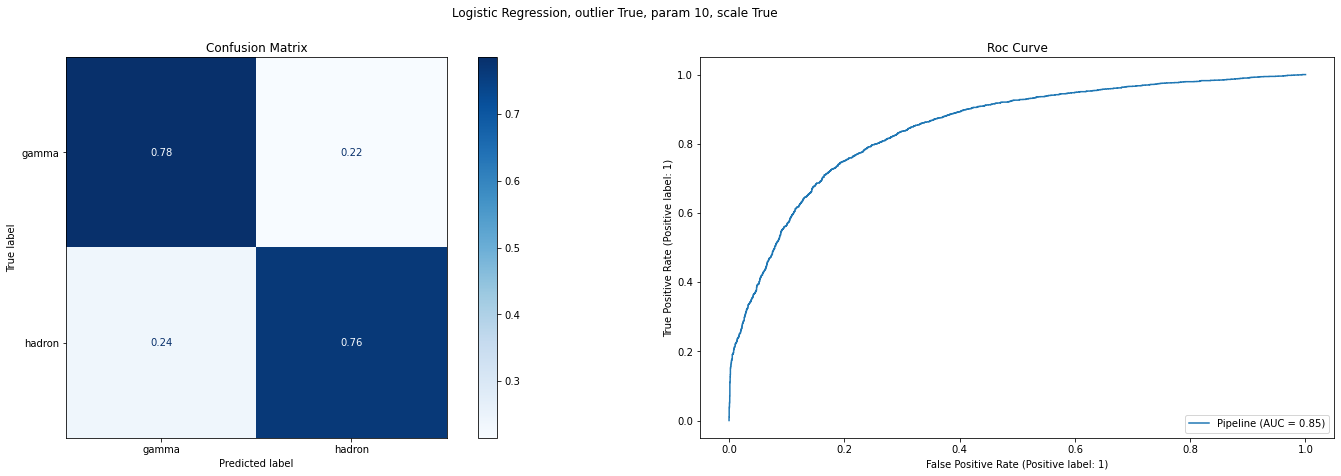


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 15, scale True = 0.7012828417183059
best parameter Logistic Regression, outlier True, param 15, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__penalty': 'l1', 'classifier__C': 0.02}



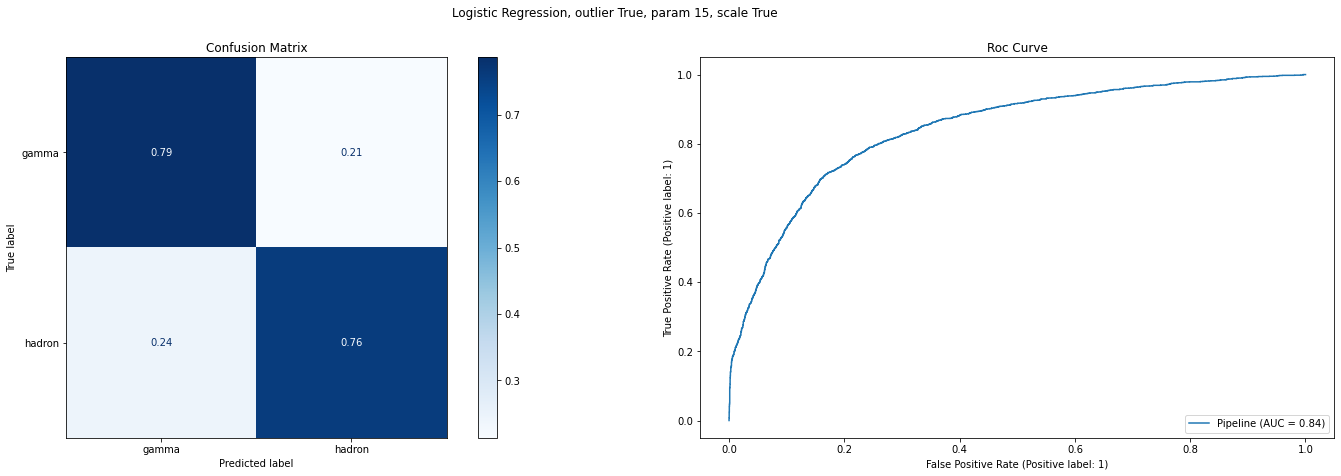


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 20, scale True = 0.6970598824017453
best parameter Logistic Regression, outlier True, param 20, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__penalty': 'l2', 'classifier__C': 0.02}



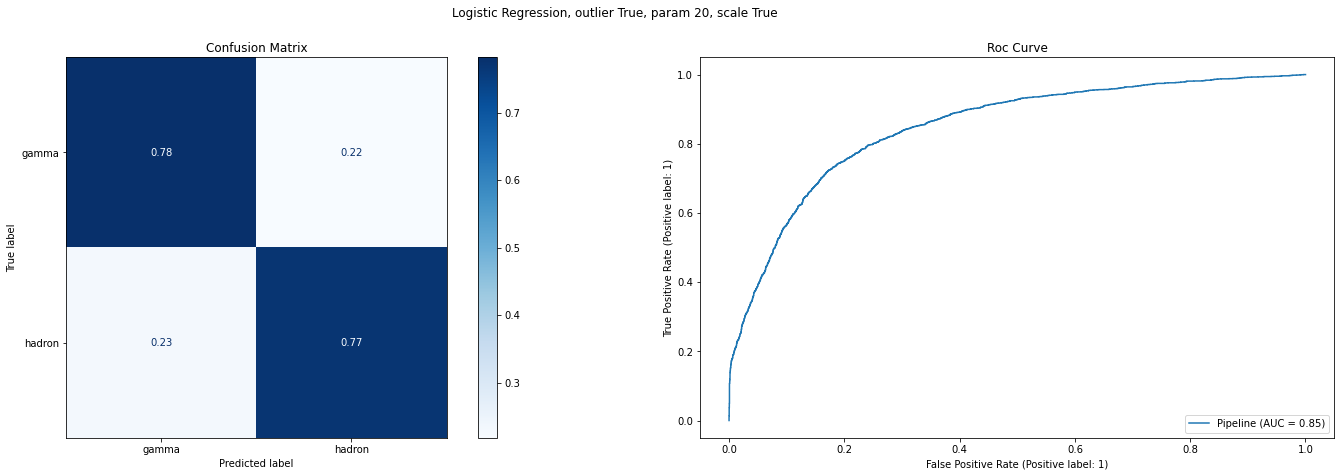


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 30, scale True = 0.7002647737736855
best parameter Logistic Regression, outlier True, param 30, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 8, 'classifier__penalty': 'l1', 'classifier__C': 0.02}



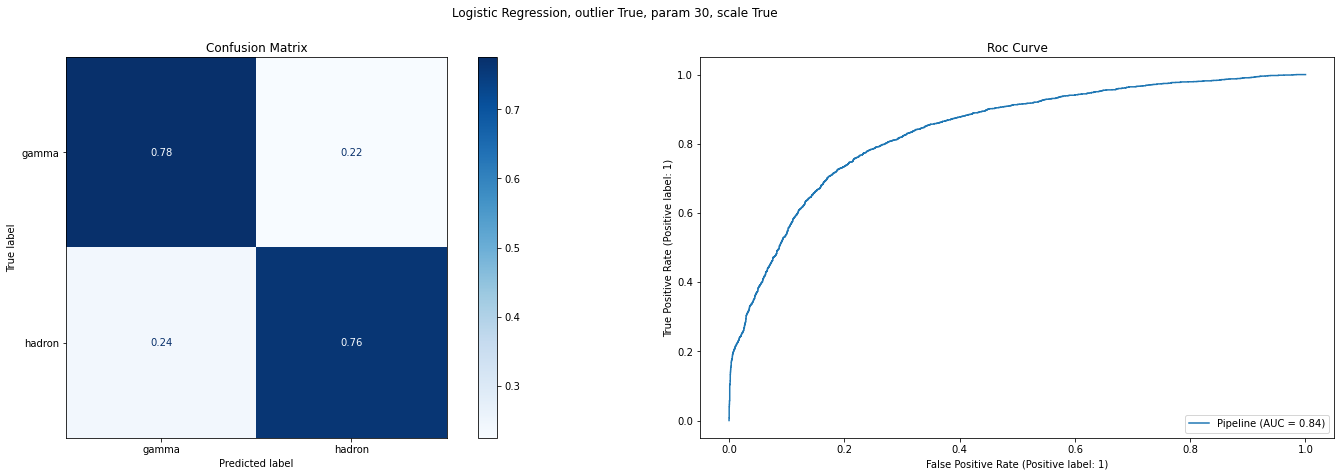


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier False, scale True = 0.7015125001029571
best parameter Logistic Regression, outlier False, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 10, 'classifier__penalty': 'l1', 'classifier__C': 0.02}



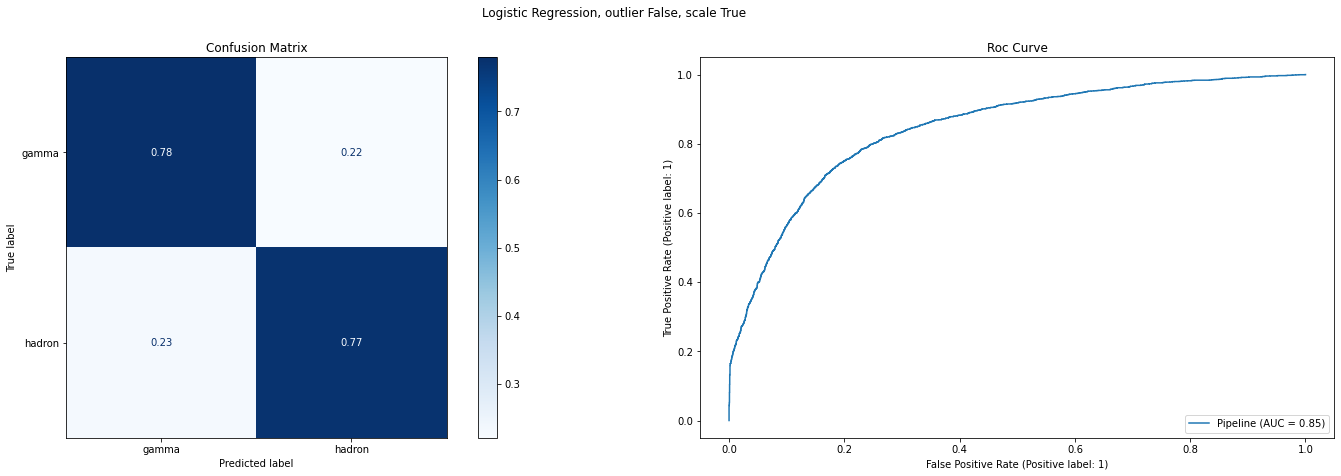

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 2, scale False = 0.7032325884449285
best parameter Logistic Regression, outlier True, param 2, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__penalty': 'l1', 'classifier__C': 0.15}



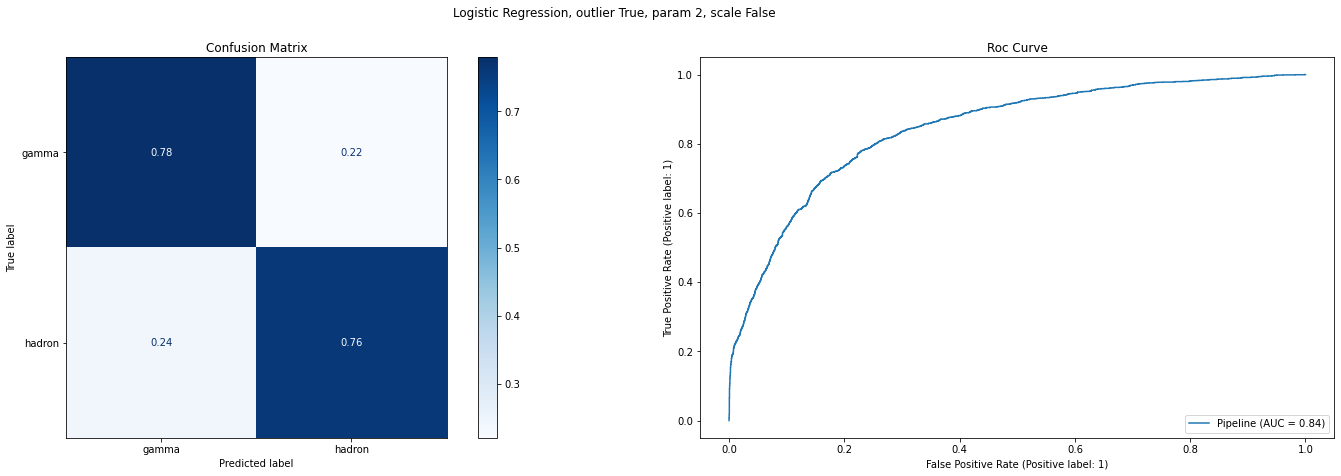


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 3, scale False = 0.7048680288345132
best parameter Logistic Regression, outlier True, param 3, scale False = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 8, 'classifier__penalty': 'l1', 'classifier__C': 0.2}



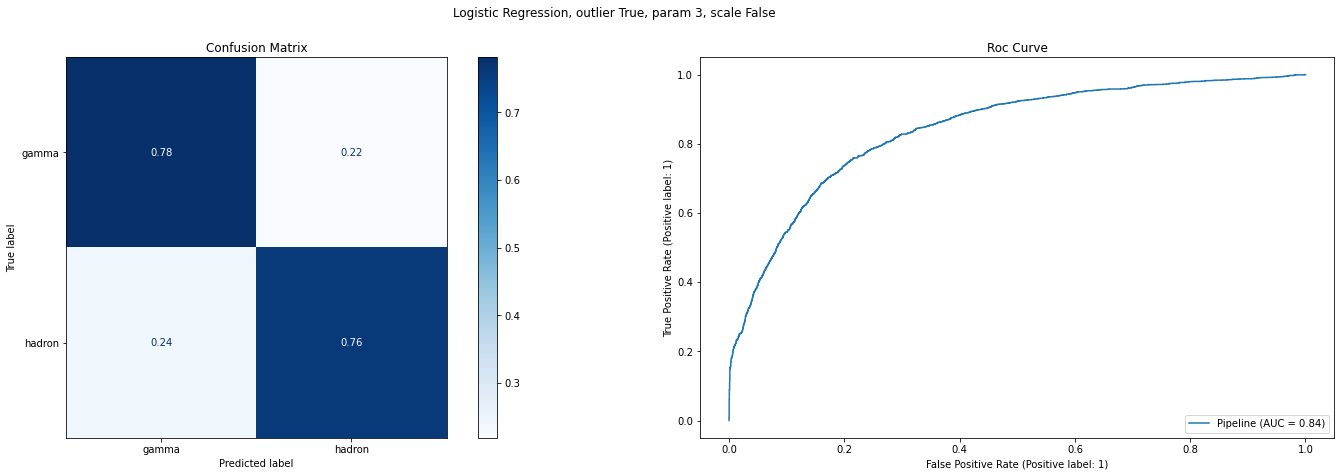


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 5, scale False = 0.7029263408617145
best parameter Logistic Regression, outlier True, param 5, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 5, 'classifier__penalty': 'l2', 'classifier__C': 0.2}



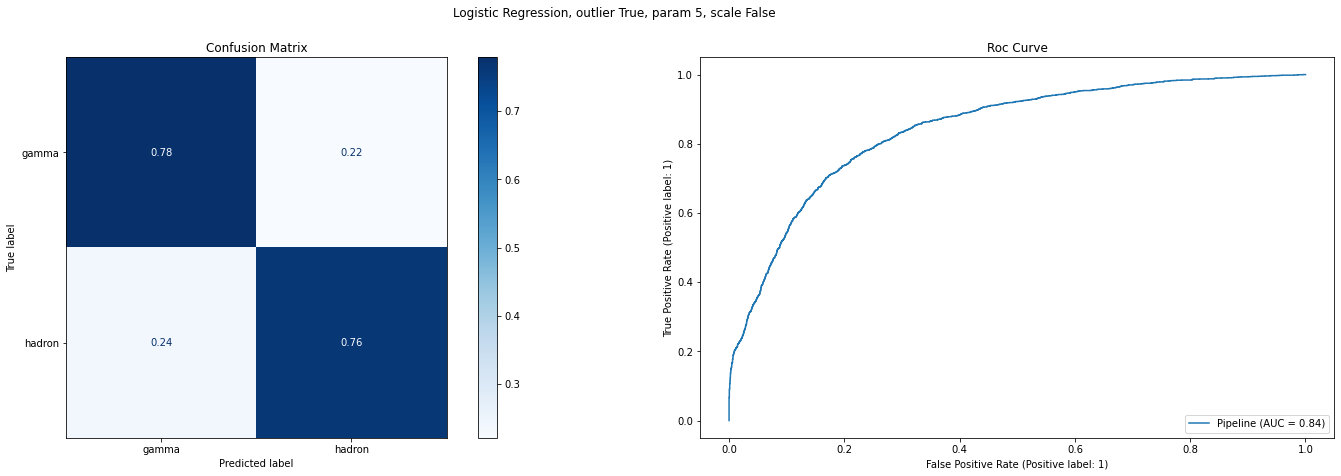


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 10, scale False = 0.6968717617462308
best parameter Logistic Regression, outlier True, param 10, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 7, 'classifier__penalty': 'l1', 'classifier__C': 0.1}



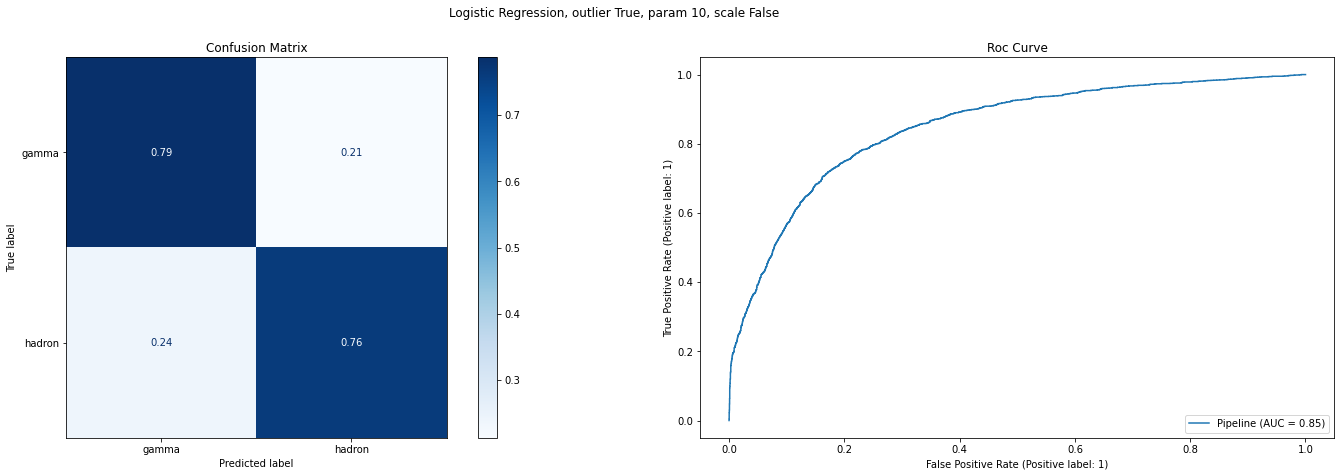


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 15, scale False = 0.700240822380502
best parameter Logistic Regression, outlier True, param 15, scale False = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 5, 'classifier__penalty': 'l1', 'classifier__C': 0.15}



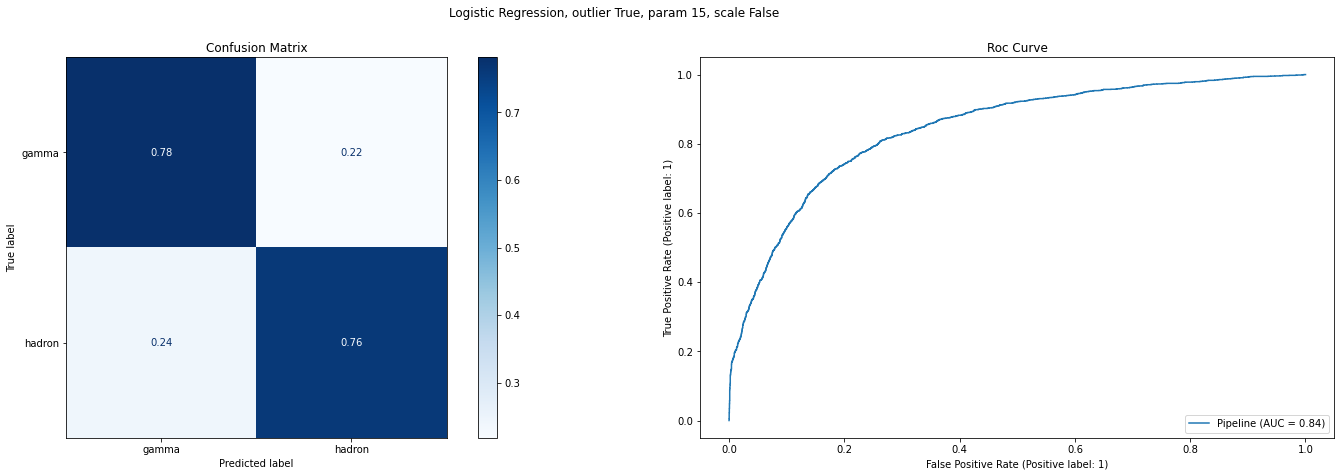


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 20, scale False = 0.696504732230248
best parameter Logistic Regression, outlier True, param 20, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__penalty': 'l2', 'classifier__C': 0.2}



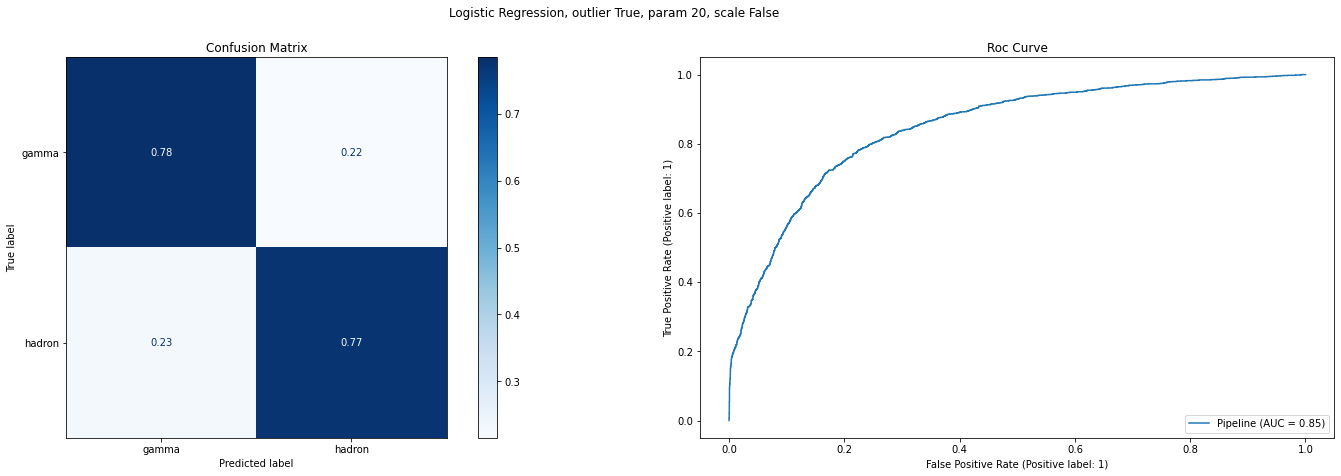


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 30, scale False = 0.6990864207378719
best parameter Logistic Regression, outlier True, param 30, scale False = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 5, 'classifier__penalty': 'l1', 'classifier__C': 0.2}



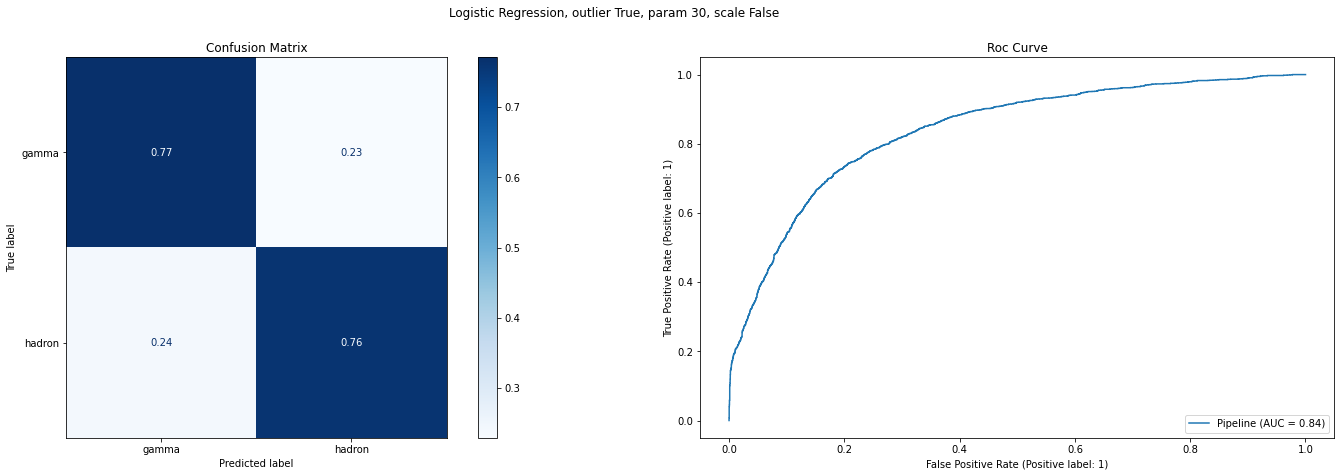


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier False, scale False = 0.6993635106505263
best parameter Logistic Regression, outlier False, scale False = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 10, 'classifier__penalty': 'l1', 'classifier__C': 0.1}



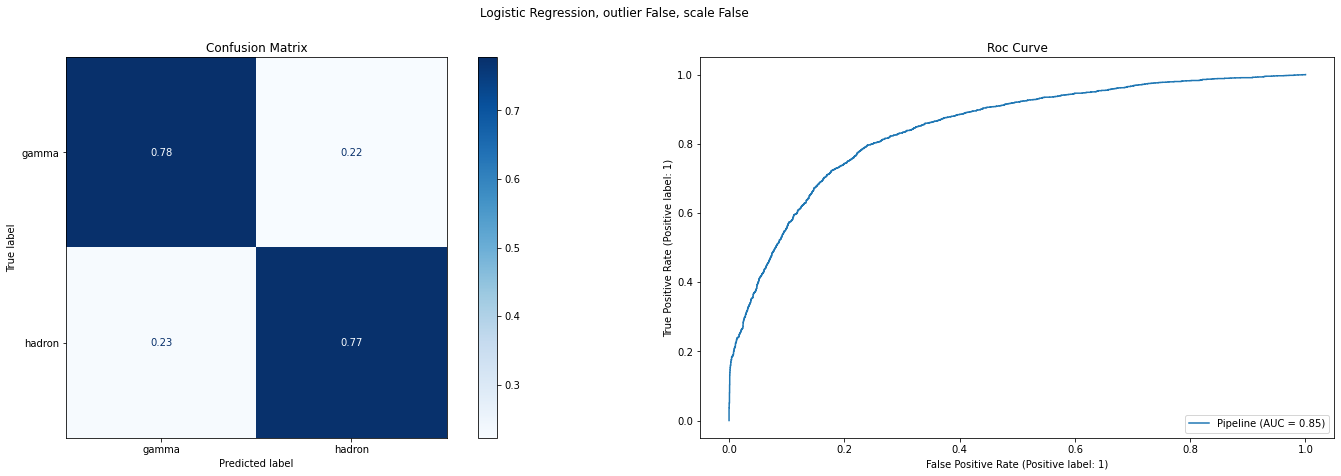

In [13]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='liblinear', random_state=42)
param_logistic = {'smote__sampling_strategy':["minority", 'all'],
                  'smote__k_neighbors': [5,7,8,10],
                  'classifier__penalty': ['l1', 'l2'],
                  'classifier__C': [0.02, 0.05, 0.08, .1, .15, .2],
                }

outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'Logistic Regression, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, logistic, title, param_logistic, skf, 'BorderlineSMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'Logistic Regression, outlier {o}, scale {s}'
            evaluate_model(X, y, logistic, title, param_logistic, skf, 'BorderlineSMOTE')

# Logistic Regression with SMOTE

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 2, scale True = 0.7045652434206775
best parameter Logistic Regression, outlier True, param 2, scale True = {'classifier__penalty': 'l1', 'classifier__C': 0.08}



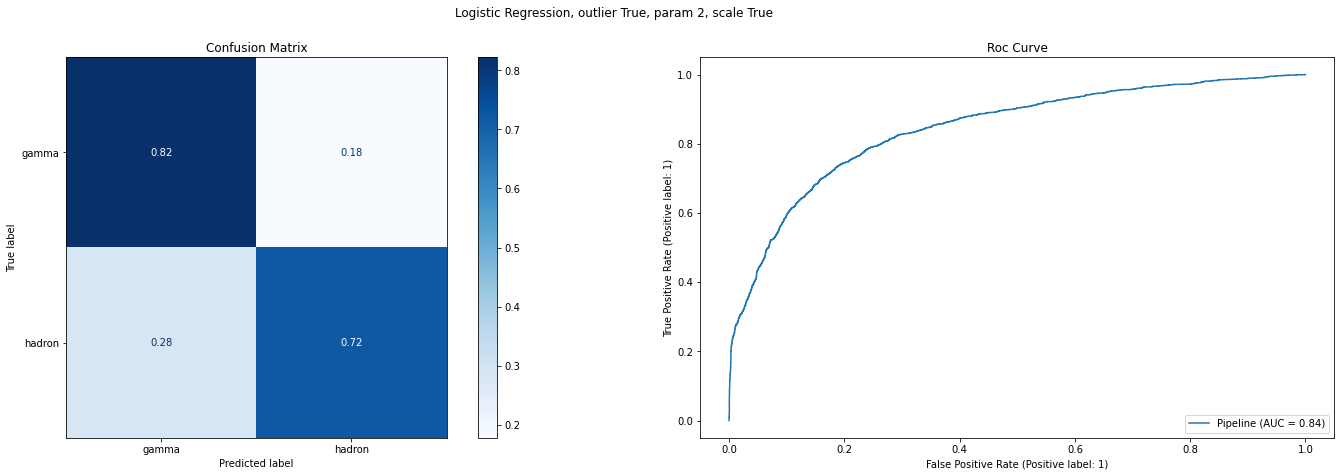


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 3, scale True = 0.7037405192661466
best parameter Logistic Regression, outlier True, param 3, scale True = {'classifier__penalty': 'l1', 'classifier__C': 0.02}



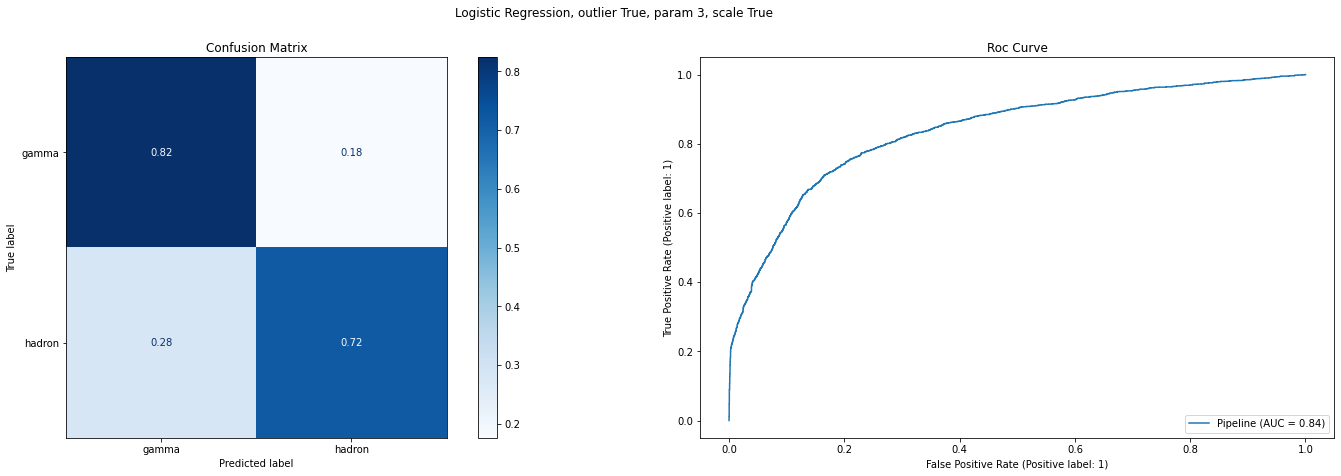


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 5, scale True = 0.7012319791391683
best parameter Logistic Regression, outlier True, param 5, scale True = {'classifier__penalty': 'l1', 'classifier__C': 0.05}



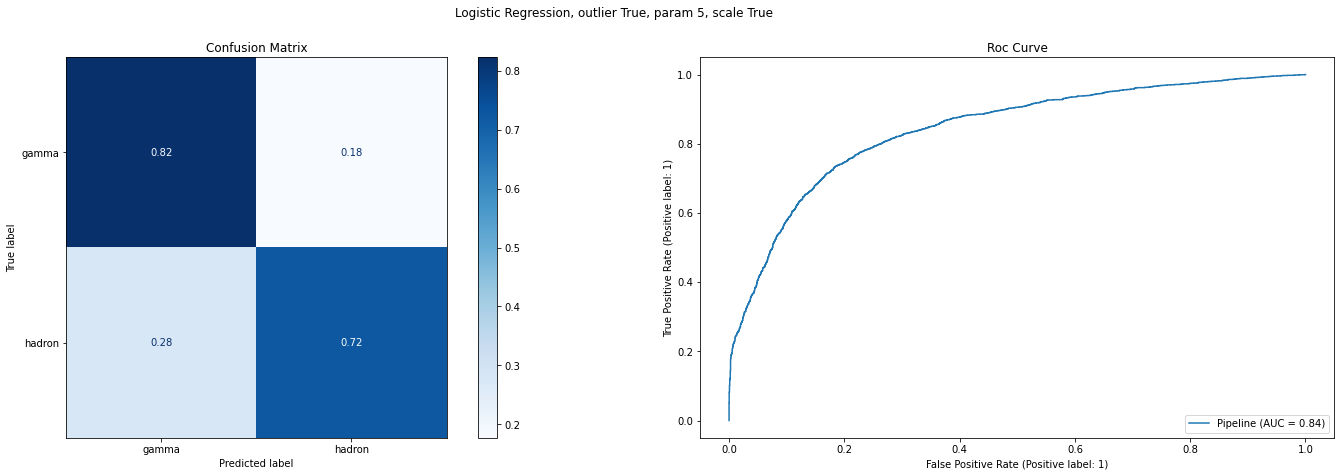


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 10, scale True = 0.6973232699756263
best parameter Logistic Regression, outlier True, param 10, scale True = {'classifier__penalty': 'l2', 'classifier__C': 0.05}



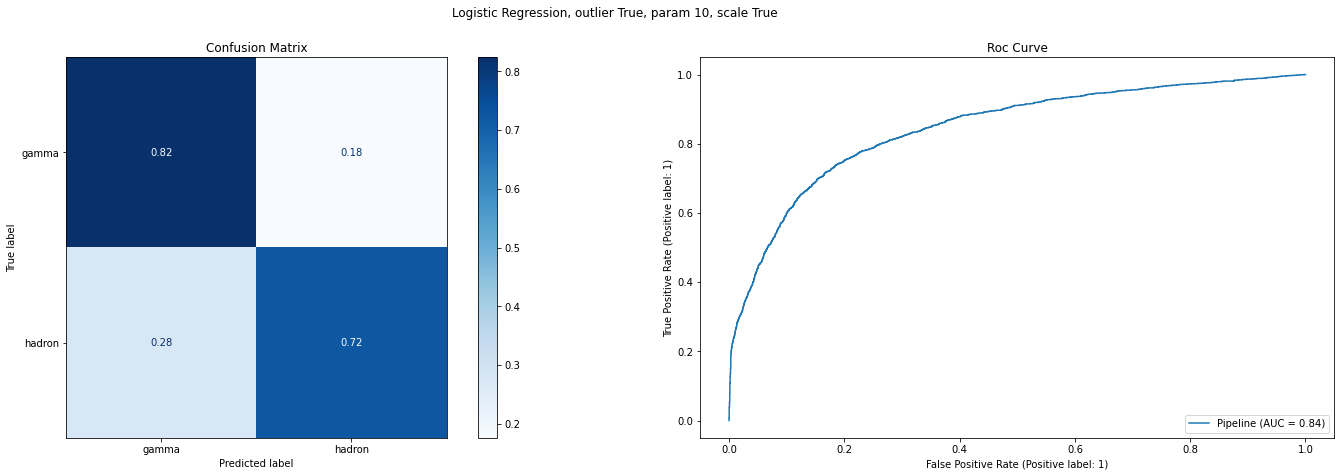


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 15, scale True = 0.6994974397467453
best parameter Logistic Regression, outlier True, param 15, scale True = {'classifier__penalty': 'l2', 'classifier__C': 0.02}



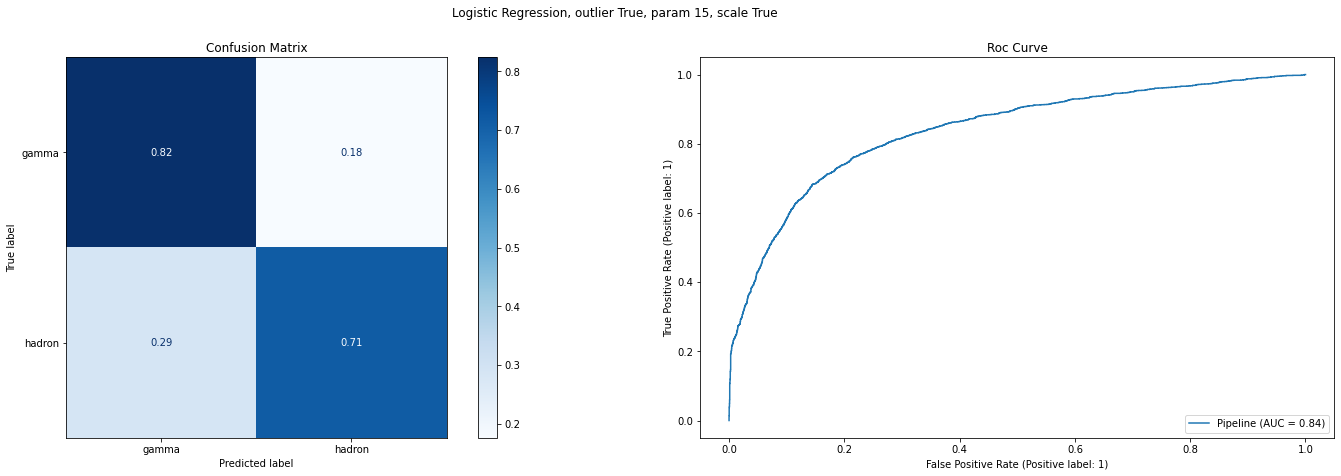


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 20, scale True = 0.697510993499261
best parameter Logistic Regression, outlier True, param 20, scale True = {'classifier__penalty': 'l1', 'classifier__C': 0.02}



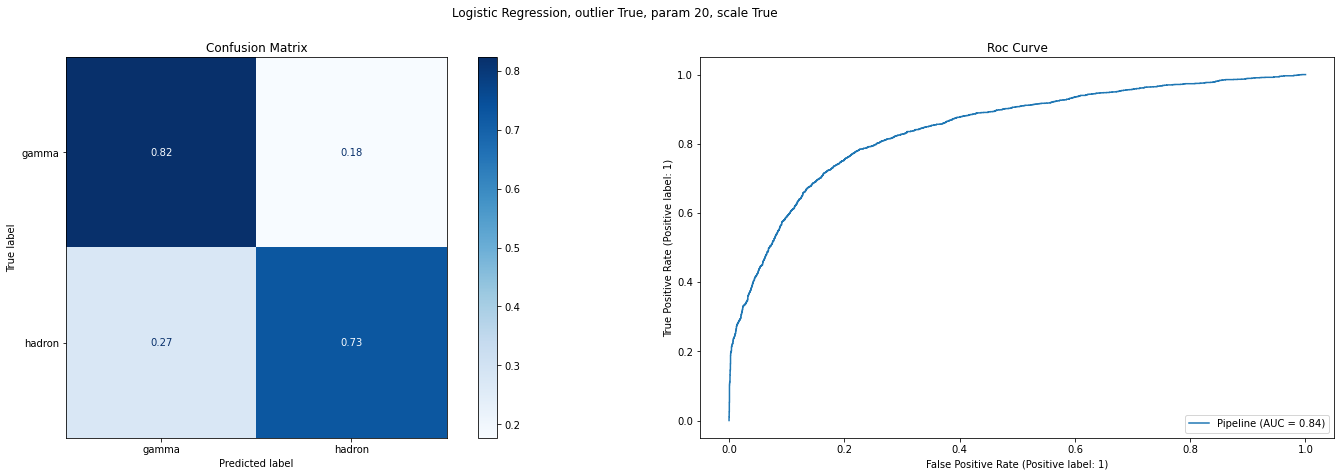


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 30, scale True = 0.6966541797002188
best parameter Logistic Regression, outlier True, param 30, scale True = {'classifier__penalty': 'l2', 'classifier__C': 0.02}



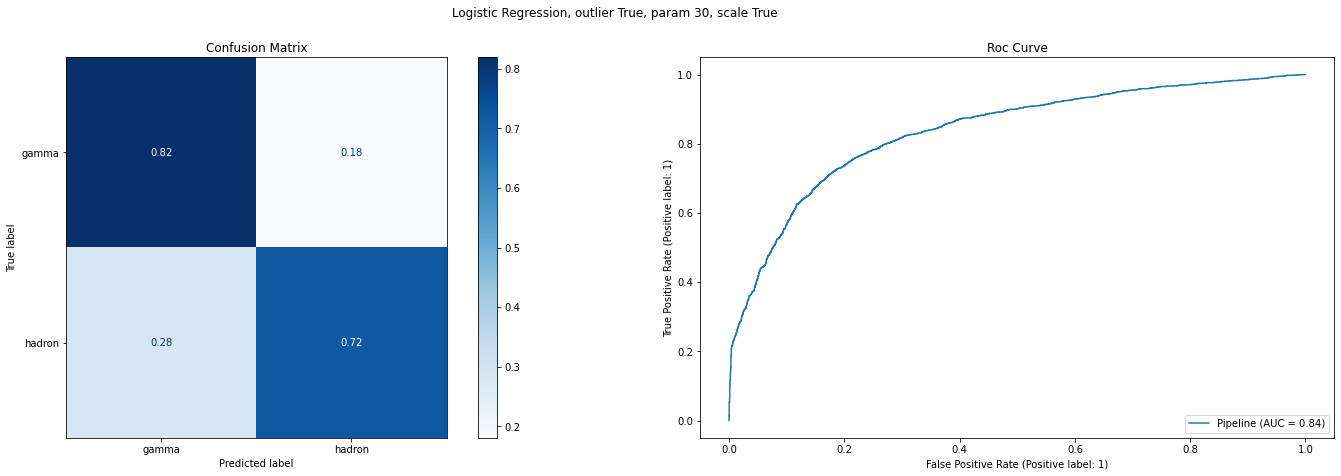


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier False, scale True = 0.6993817766955842
best parameter Logistic Regression, outlier False, scale True = {'classifier__penalty': 'l1', 'classifier__C': 0.02}



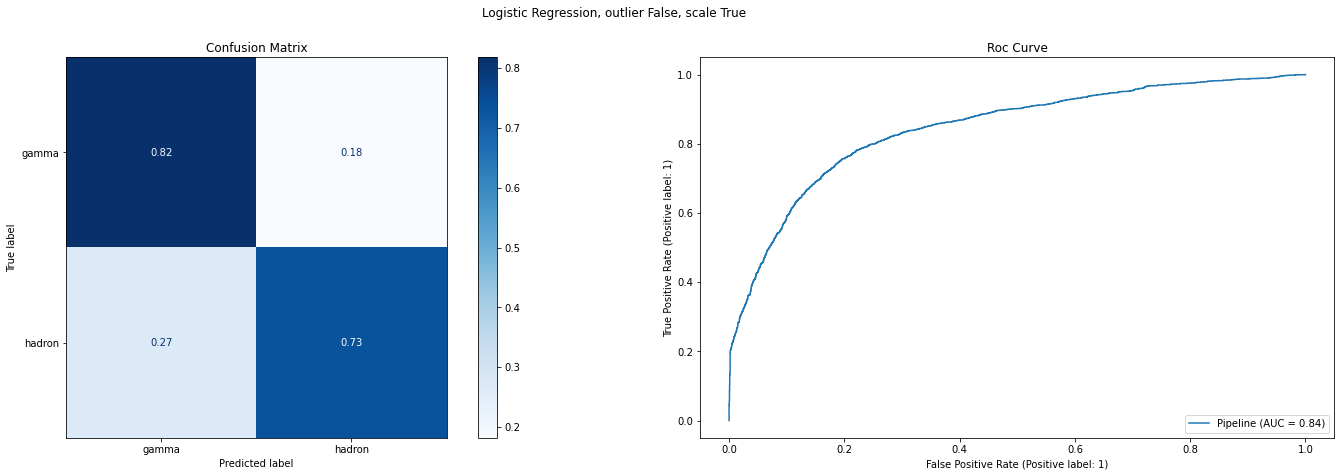

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 2, scale False = 0.7038396898124138
best parameter Logistic Regression, outlier True, param 2, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.2}



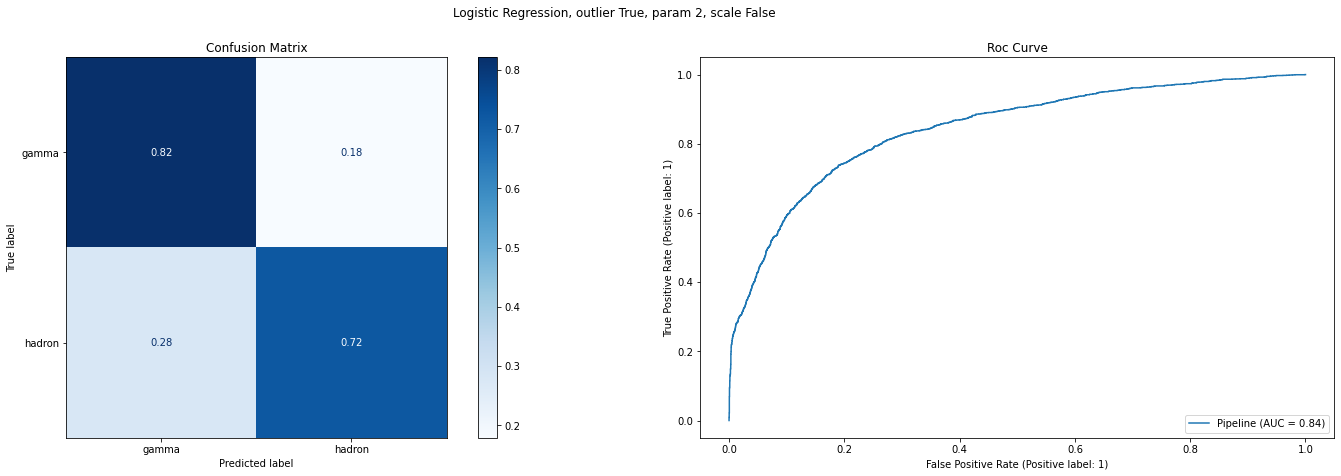


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 3, scale False = 0.7027961182348407
best parameter Logistic Regression, outlier True, param 3, scale False = {'classifier__penalty': 'l2', 'classifier__C': 0.2}



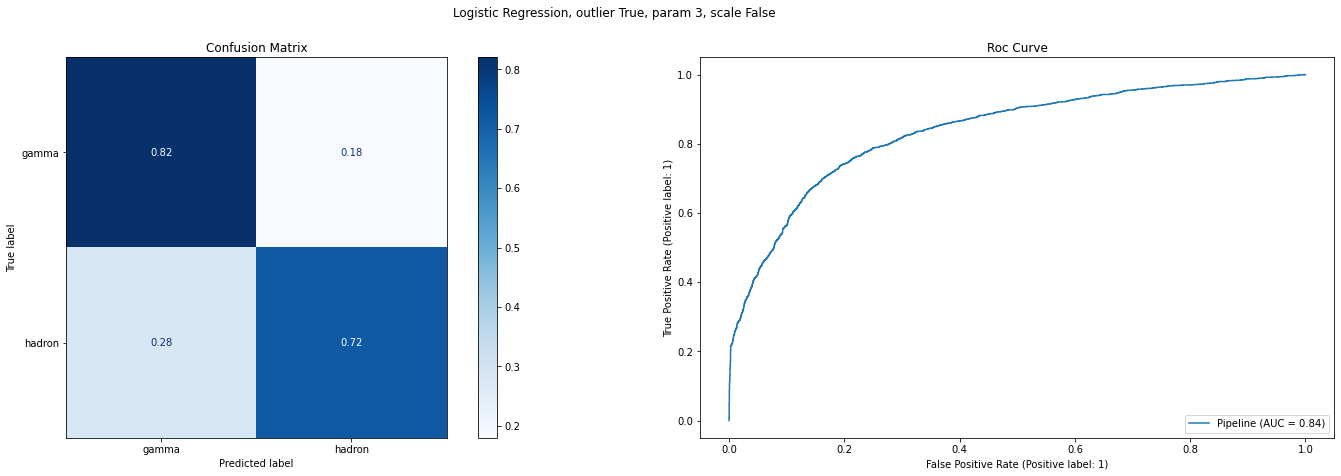


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 5, scale False = 0.7008511614873748
best parameter Logistic Regression, outlier True, param 5, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.15}



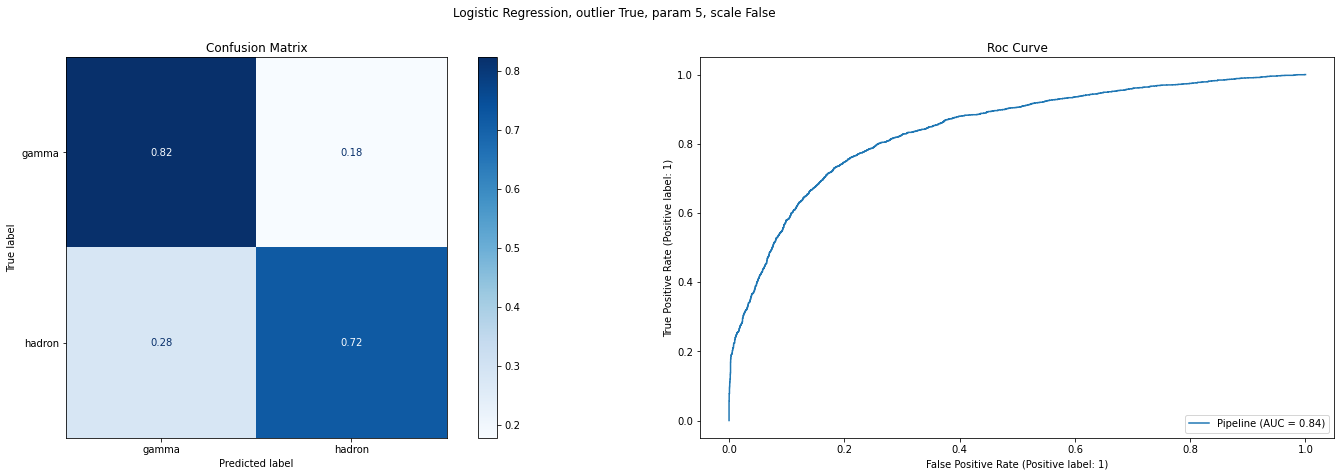


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 10, scale False = 0.6952232177524095
best parameter Logistic Regression, outlier True, param 10, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.1}



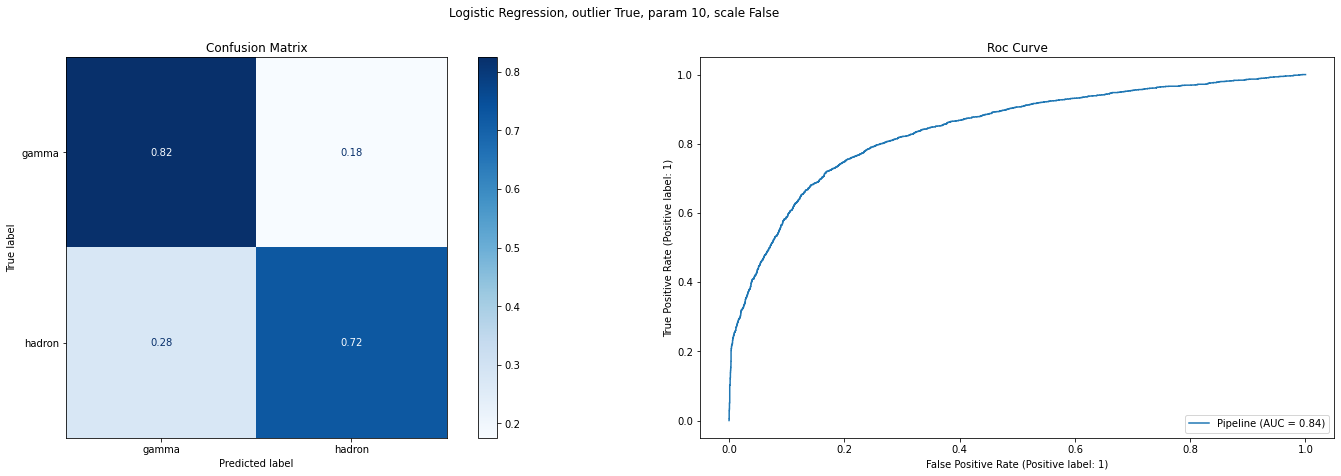


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 15, scale False = 0.6992382297195989
best parameter Logistic Regression, outlier True, param 15, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.15}



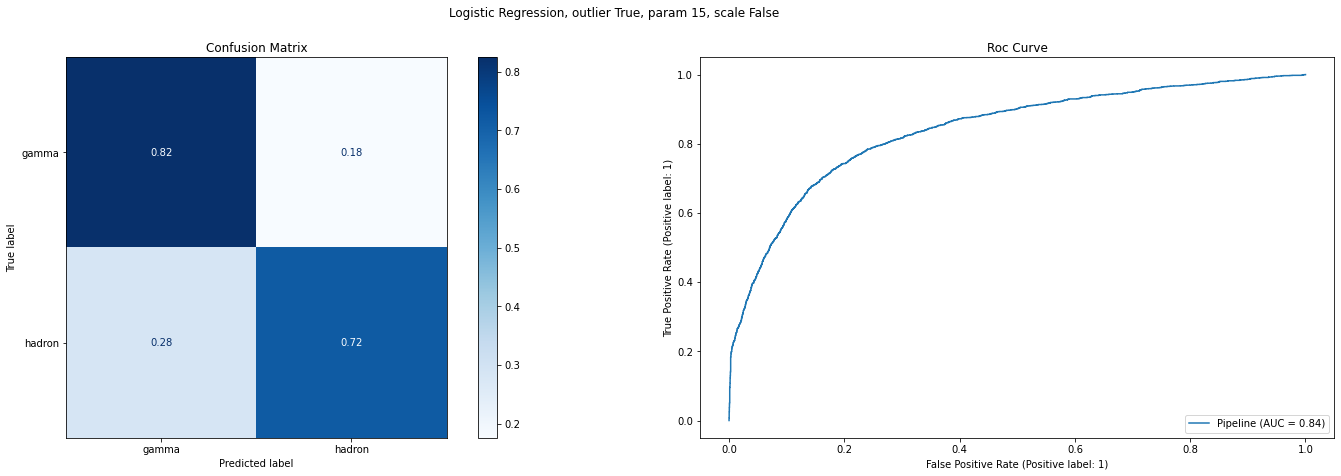


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 20, scale False = 0.6964989799504102
best parameter Logistic Regression, outlier True, param 20, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.1}



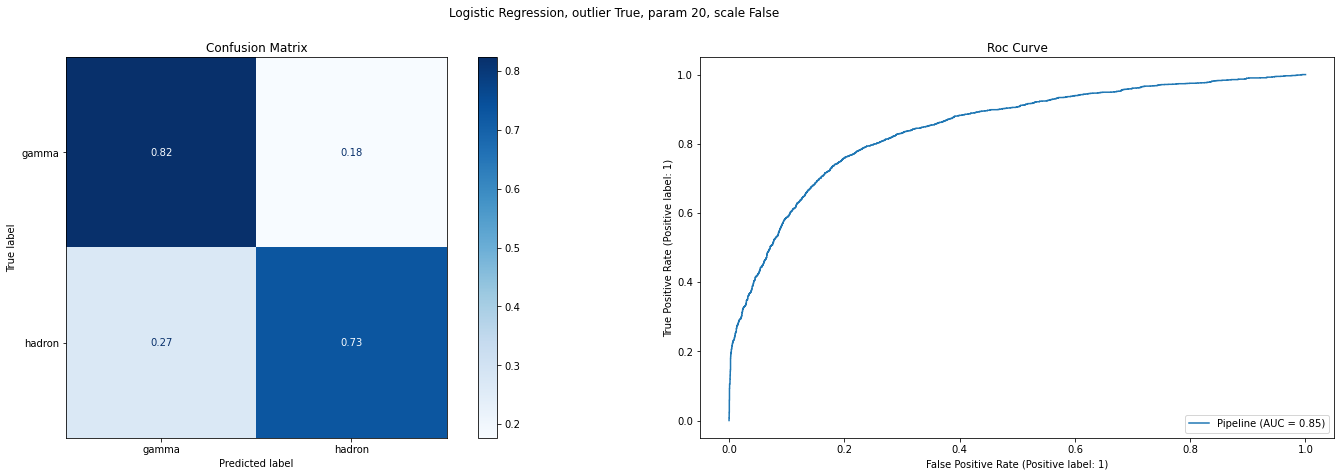


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier True, param 30, scale False = 0.6952753341683168
best parameter Logistic Regression, outlier True, param 30, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.2}



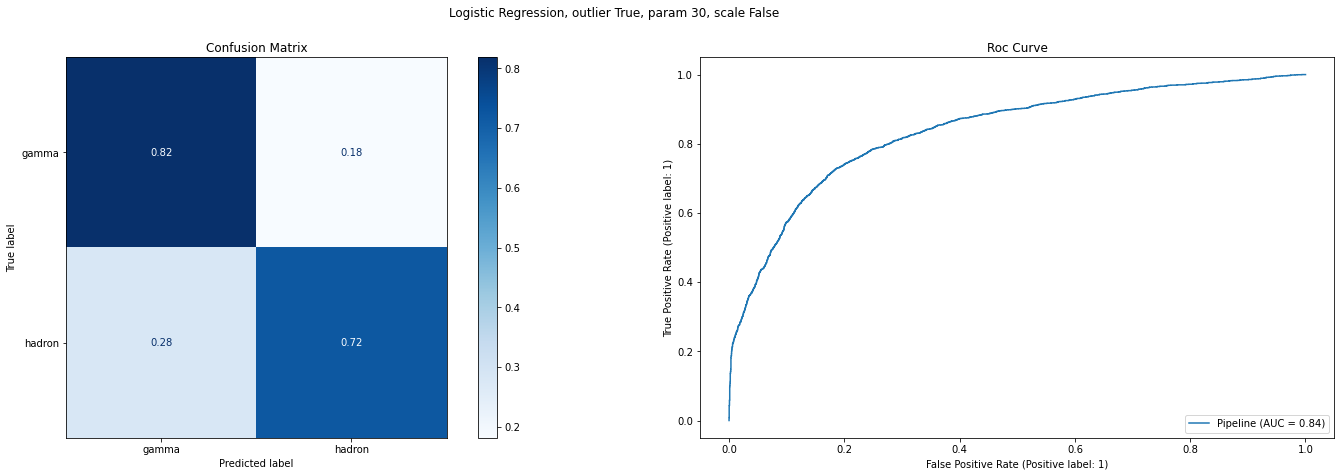


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score Logistic Regression, outlier False, scale False = 0.6984211189488562
best parameter Logistic Regression, outlier False, scale False = {'classifier__penalty': 'l1', 'classifier__C': 0.15}



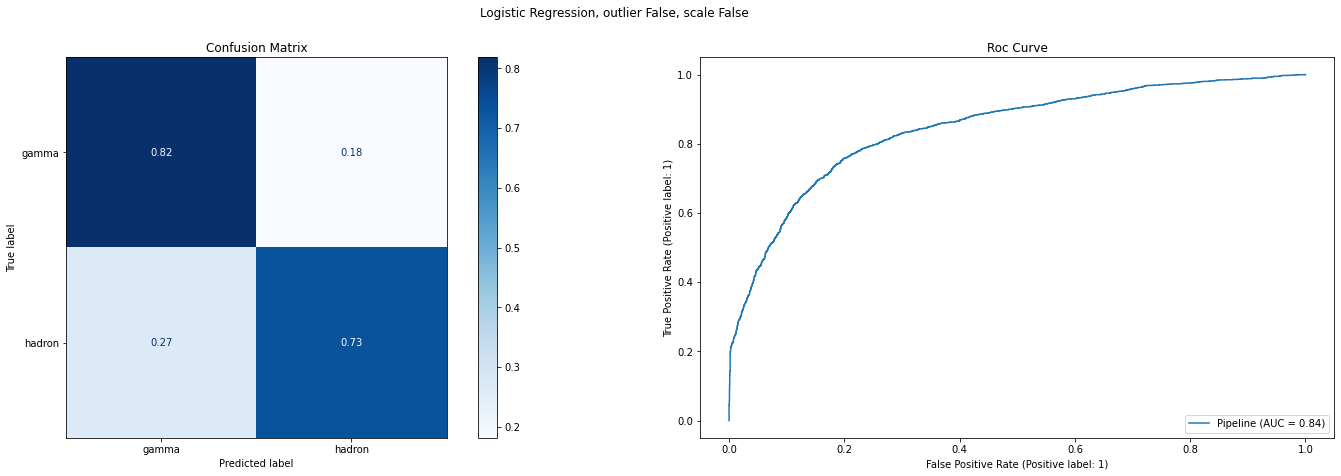

In [14]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='liblinear', random_state=42)
param_logistic = {'classifier__penalty': ['l1', 'l2'],
                  'classifier__C': [0.02, 0.05, 0.08, .1, .15, .2],
                }

outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'Logistic Regression, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, logistic, title, param_logistic, skf, 'SMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'Logistic Regression, outlier {o}, scale {s}'
            evaluate_model(X, y, logistic, title, param_logistic, skf, 'SMOTE')

# KNN with BorderLine

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 2, scale True = 0.7471885233951894
best parameter KNN, outlier True, param 2, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 10, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



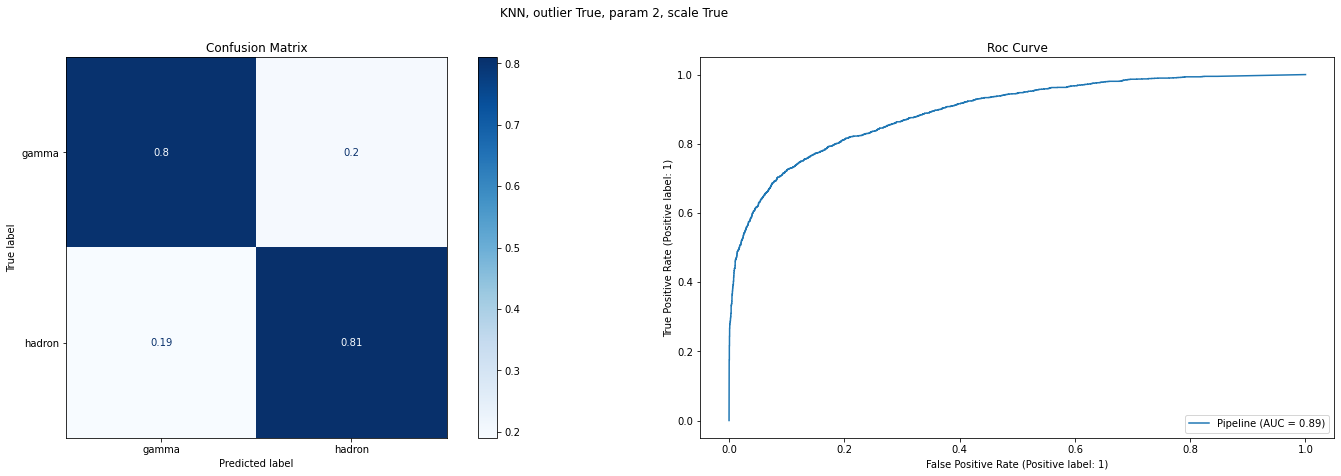


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 3, scale True = 0.7455105905747961
best parameter KNN, outlier True, param 3, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 7, 'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



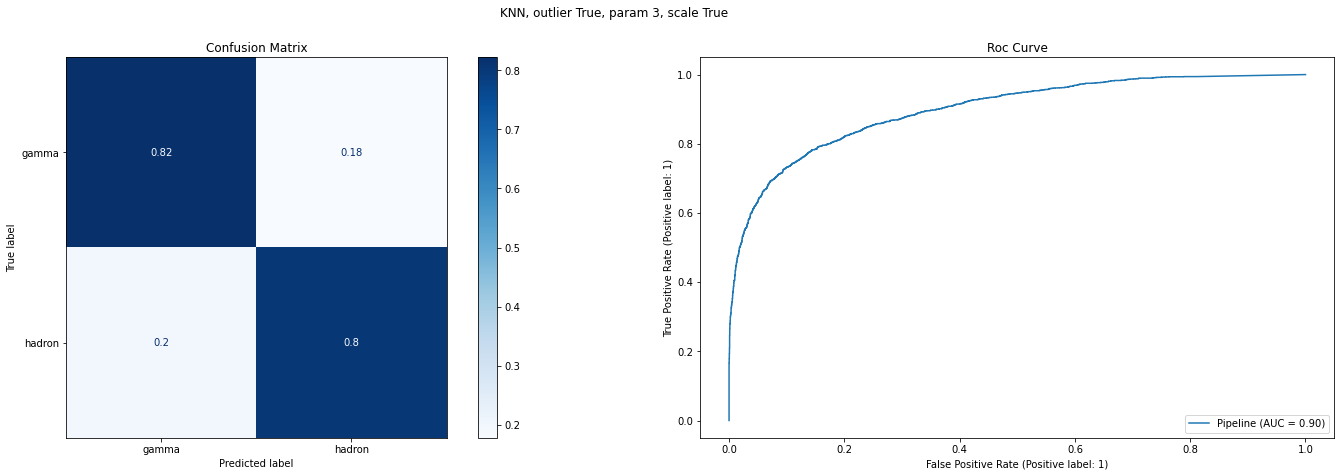


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 5, scale True = 0.7488245549767079
best parameter KNN, outlier True, param 5, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 10, 'classifier__weights': 'distance', 'classifier__n_neighbors': 50}



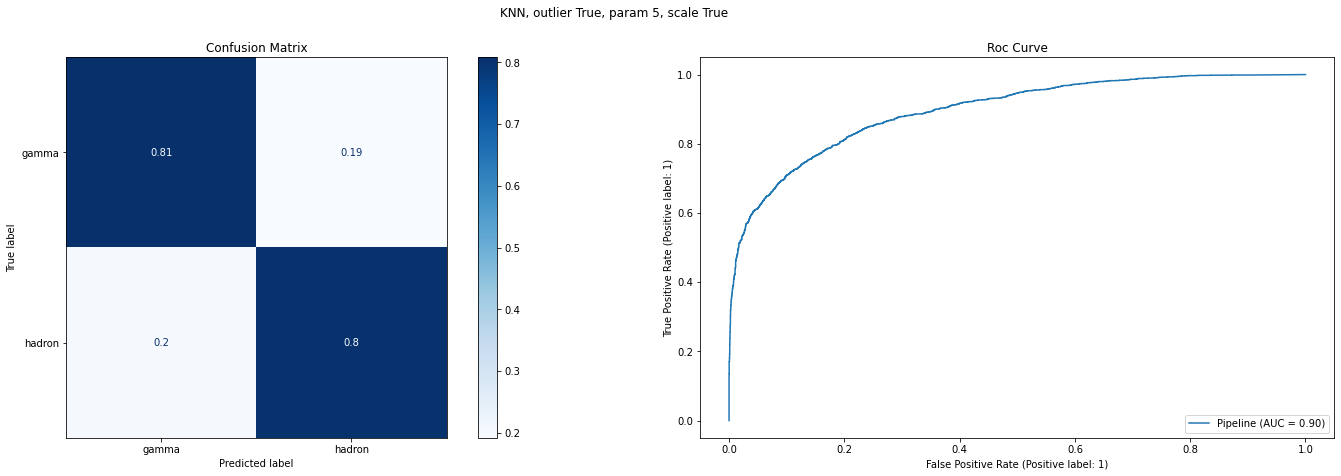


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 10, scale True = 0.7442501622718034
best parameter KNN, outlier True, param 10, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 7, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



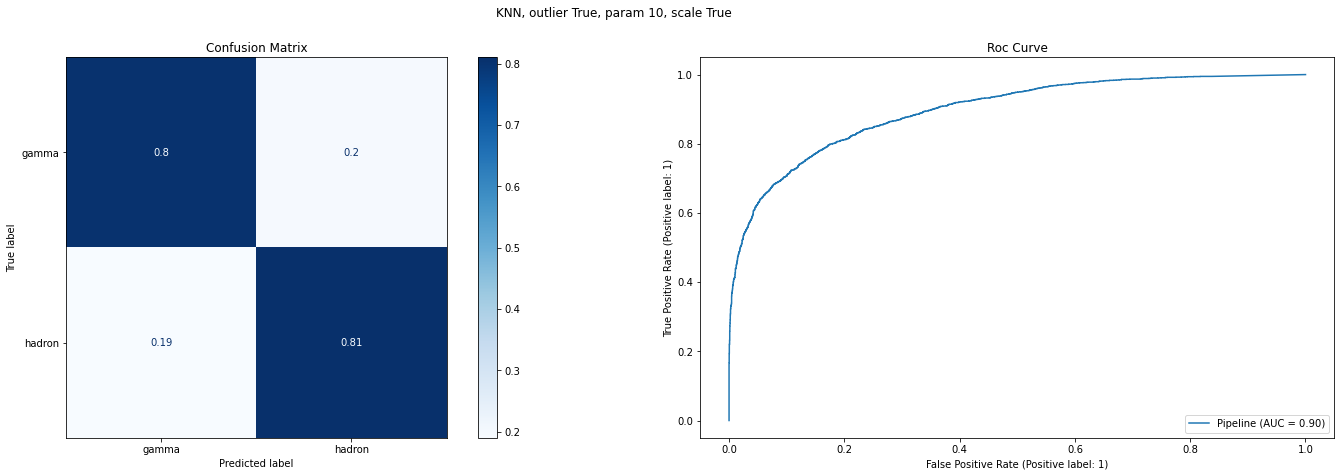


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 15, scale True = 0.7442126559459613
best parameter KNN, outlier True, param 15, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 5, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



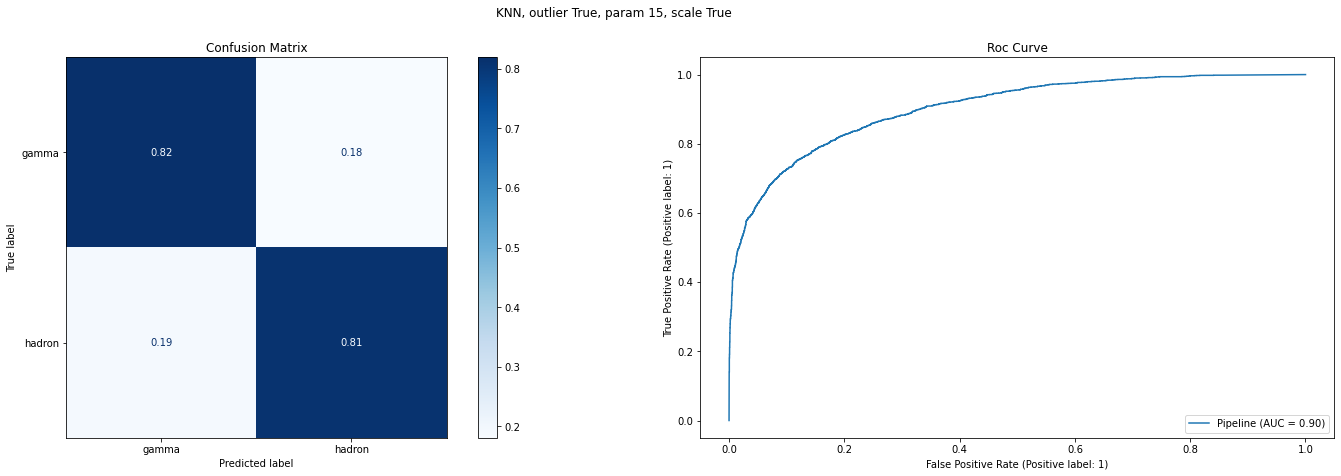


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 20, scale True = 0.744858382795197
best parameter KNN, outlier True, param 20, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 10, 'classifier__weights': 'distance', 'classifier__n_neighbors': 38}



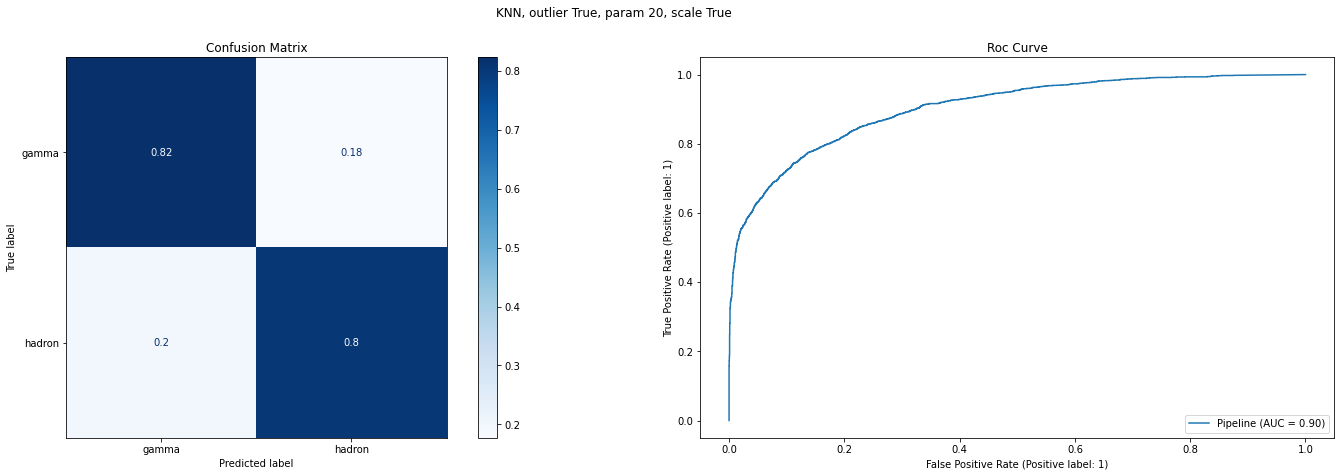


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 30, scale True = 0.7437934867914716
best parameter KNN, outlier True, param 30, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



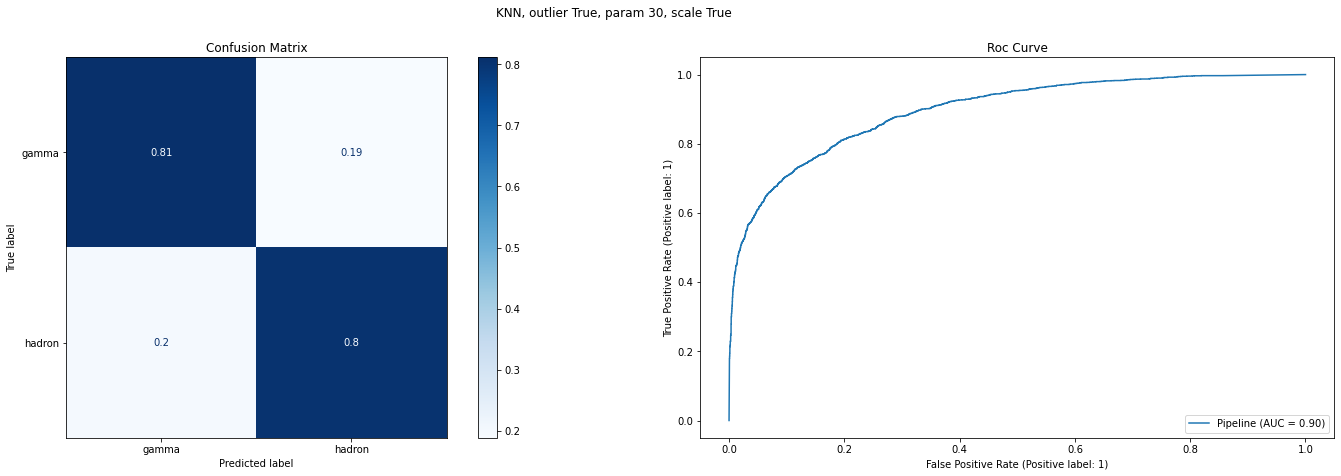


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier False, scale True = 0.7466713442121132
best parameter KNN, outlier False, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 10, 'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



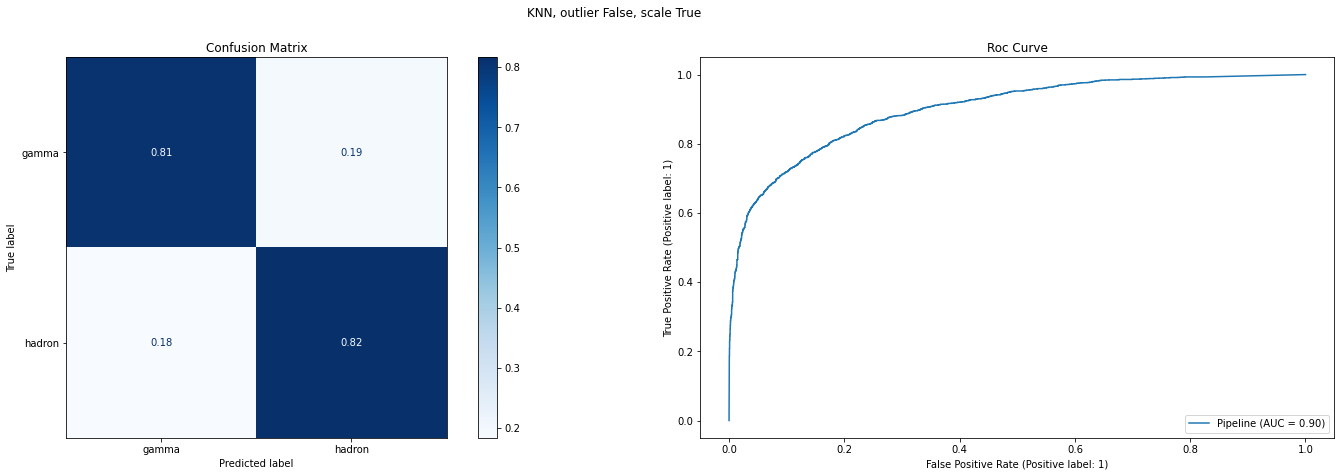

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 2, scale False = 0.697321295645544
best parameter KNN, outlier True, param 2, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 7, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



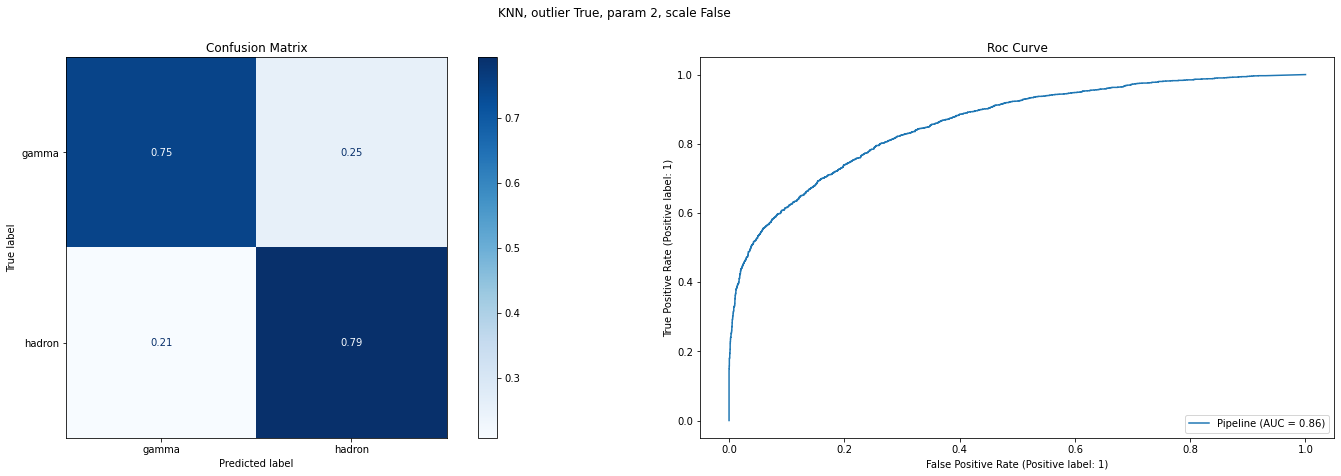


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 3, scale False = 0.6981641832456028
best parameter KNN, outlier True, param 3, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 7, 'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



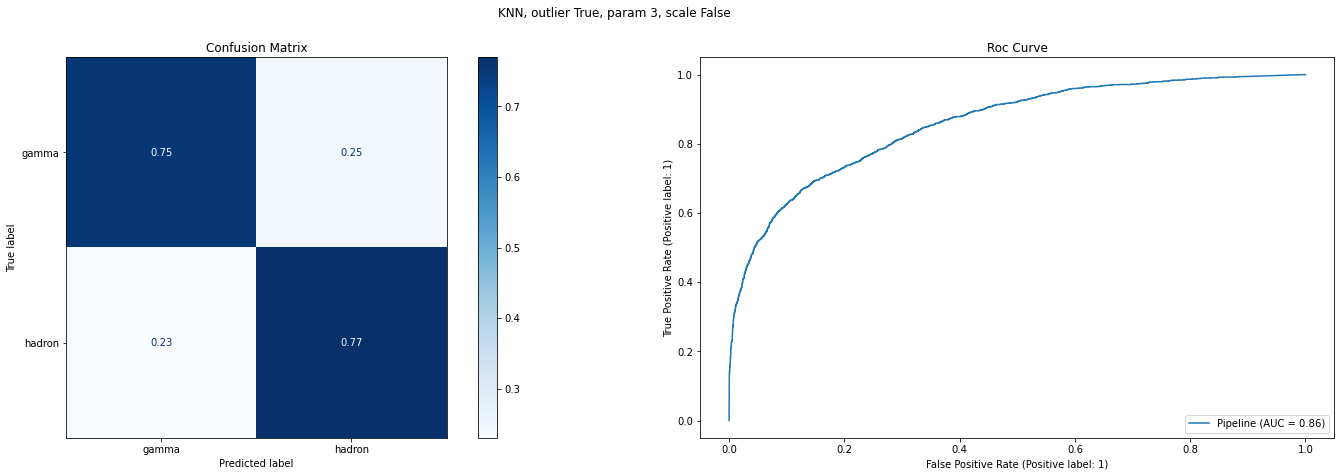


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 5, scale False = 0.6974526992265072
best parameter KNN, outlier True, param 5, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__weights': 'distance', 'classifier__n_neighbors': 50}



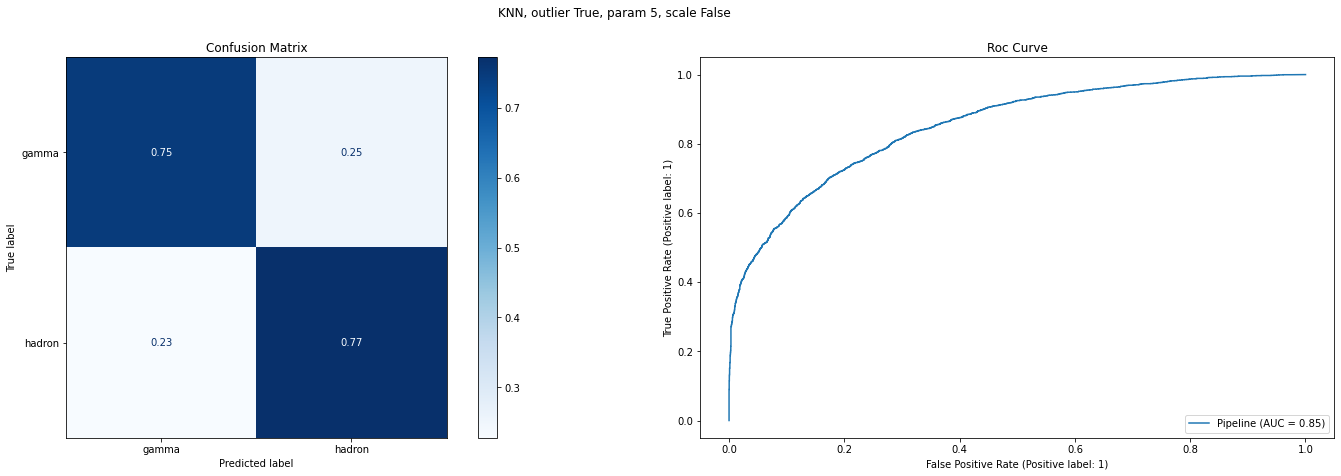


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 10, scale False = 0.6994043466321376
best parameter KNN, outlier True, param 10, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 7, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



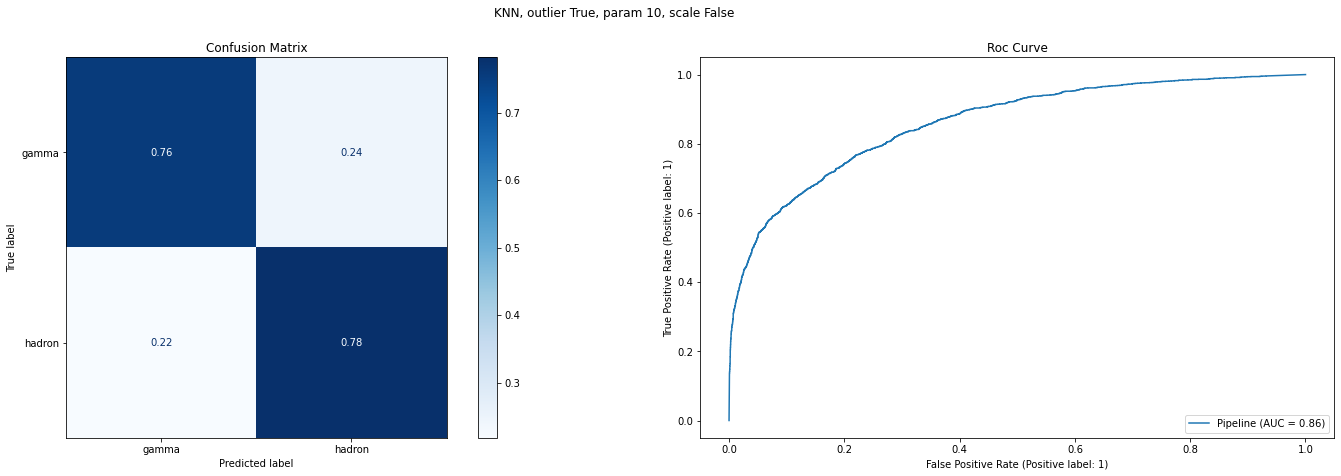


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 15, scale False = 0.690453852027333
best parameter KNN, outlier True, param 15, scale False = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 8, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



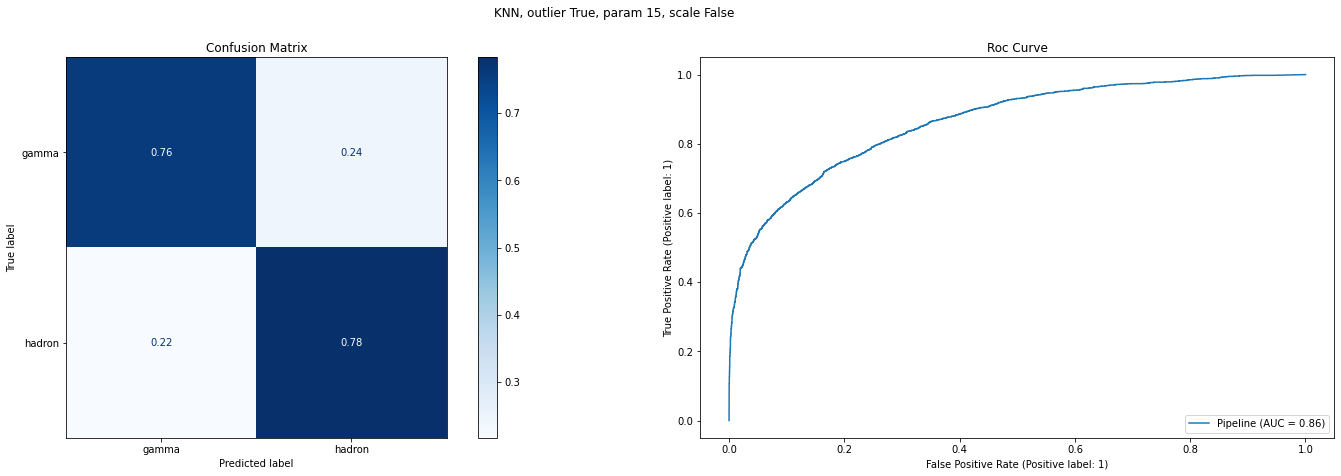


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 20, scale False = 0.6930494266992293
best parameter KNN, outlier True, param 20, scale False = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 7, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



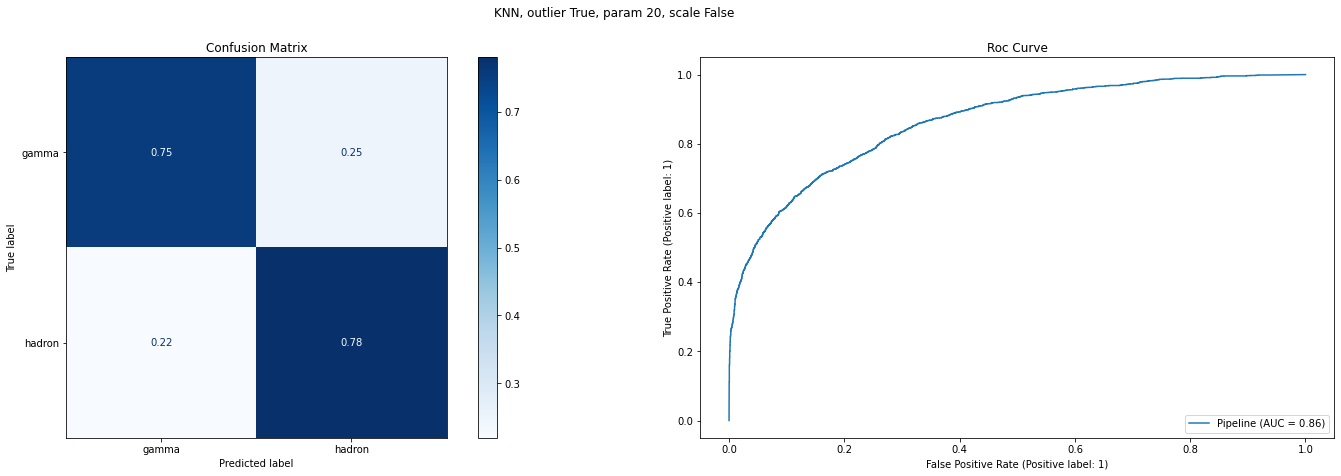


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier True, param 30, scale False = 0.6962981140510741
best parameter KNN, outlier True, param 30, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 10, 'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



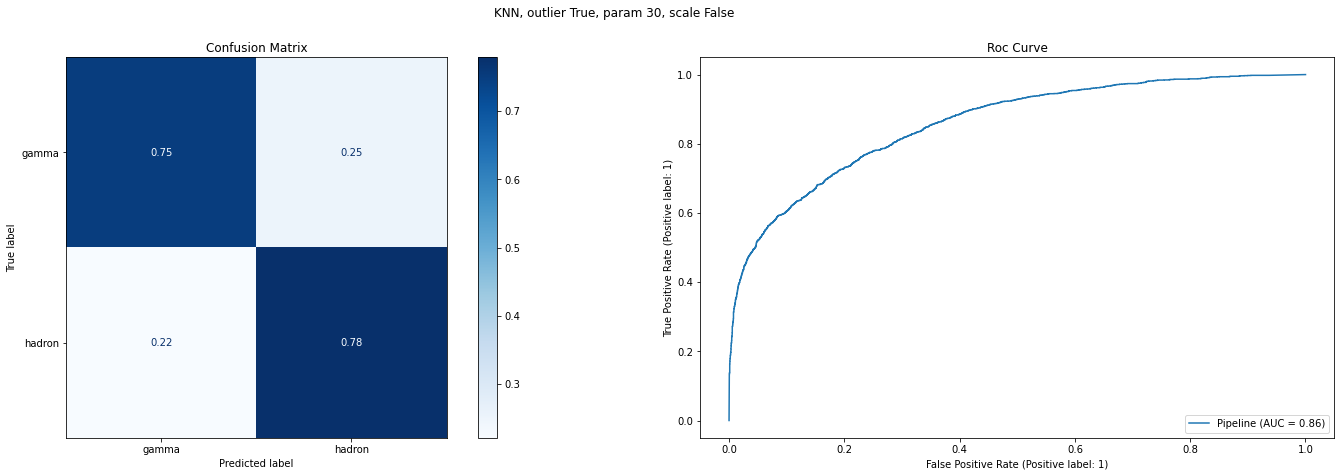


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score KNN, outlier False, scale False = 0.6955744382343451
best parameter KNN, outlier False, scale False = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 10, 'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



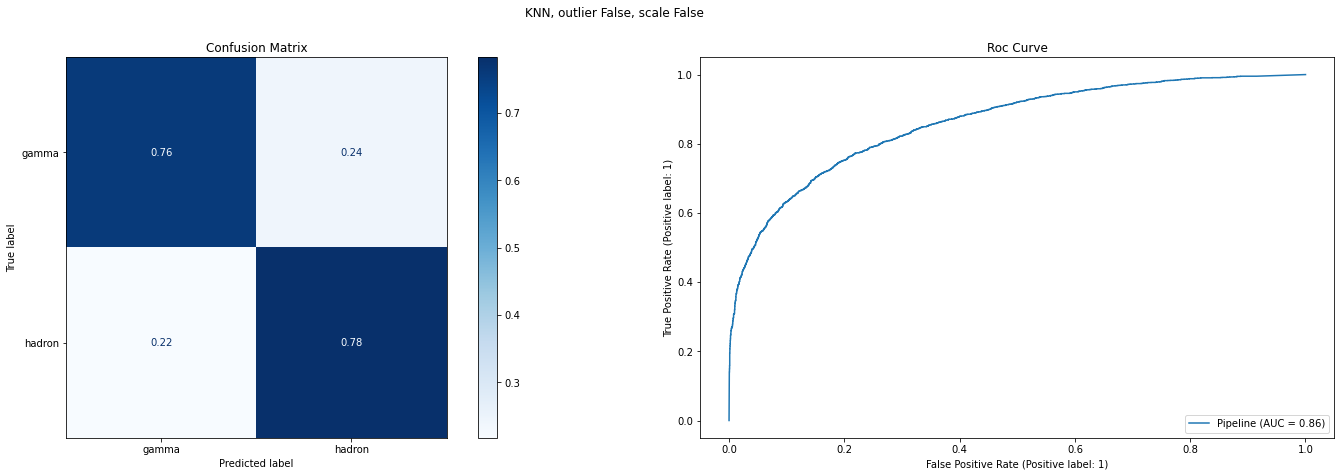

In [7]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, algorithm = 'auto', n_jobs=-1)
param_knn = {'smote__sampling_strategy':["minority", 'all'],
                'smote__k_neighbors': [5,7,8,10],
                'classifier__n_neighbors': [ 35,38,30,50  ],
                'classifier__weights': ['uniform', 'distance']
                }


outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'KNN, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, neigh, title, param_knn, skf, 'BorderlineSMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'KNN, outlier {o}, scale {s}'
            evaluate_model(X, y, neigh, title, param_knn, skf, 'BorderlineSMOTE')

# KNN with SMOTE

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 2, scale True = 0.7636735243005016
best parameter KNN, outlier True, param 2, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



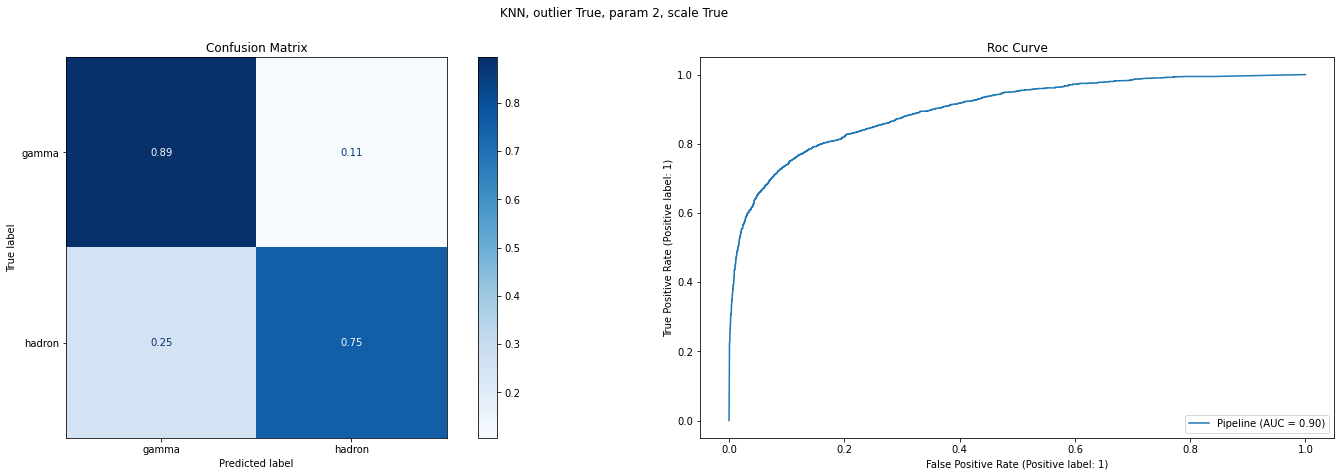


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 3, scale True = 0.7585092589236662
best parameter KNN, outlier True, param 3, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



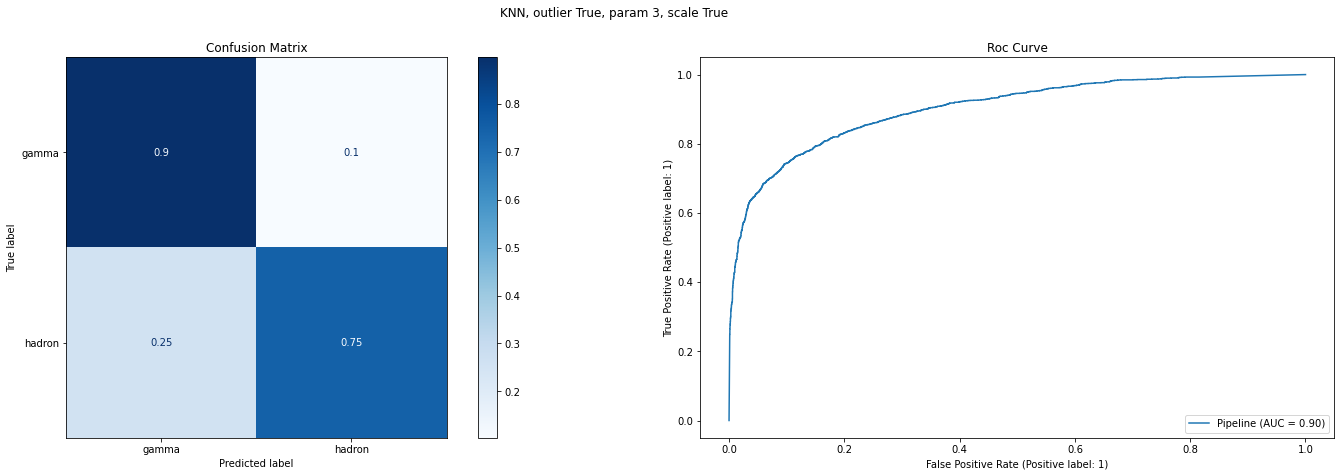


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 5, scale True = 0.7635411362864307
best parameter KNN, outlier True, param 5, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



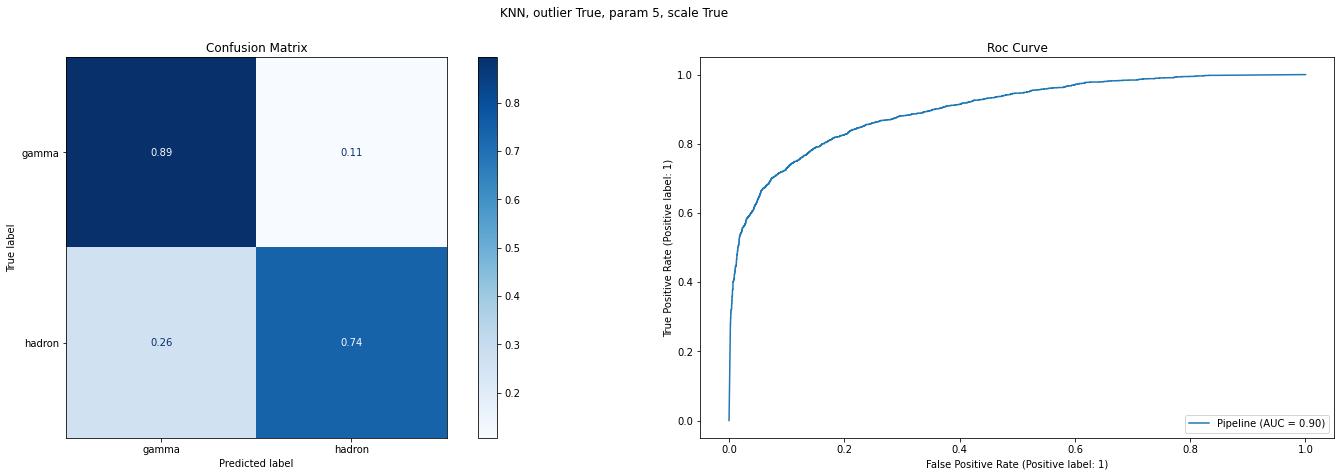


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 10, scale True = 0.7578187541847882
best parameter KNN, outlier True, param 10, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 50}



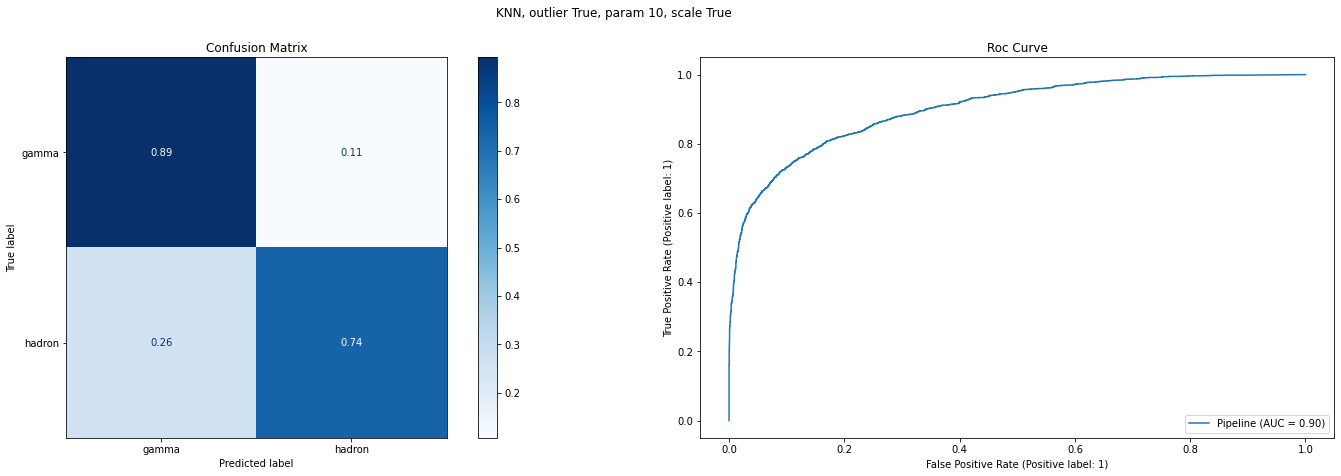


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 15, scale True = 0.7526424955872918
best parameter KNN, outlier True, param 15, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 38}



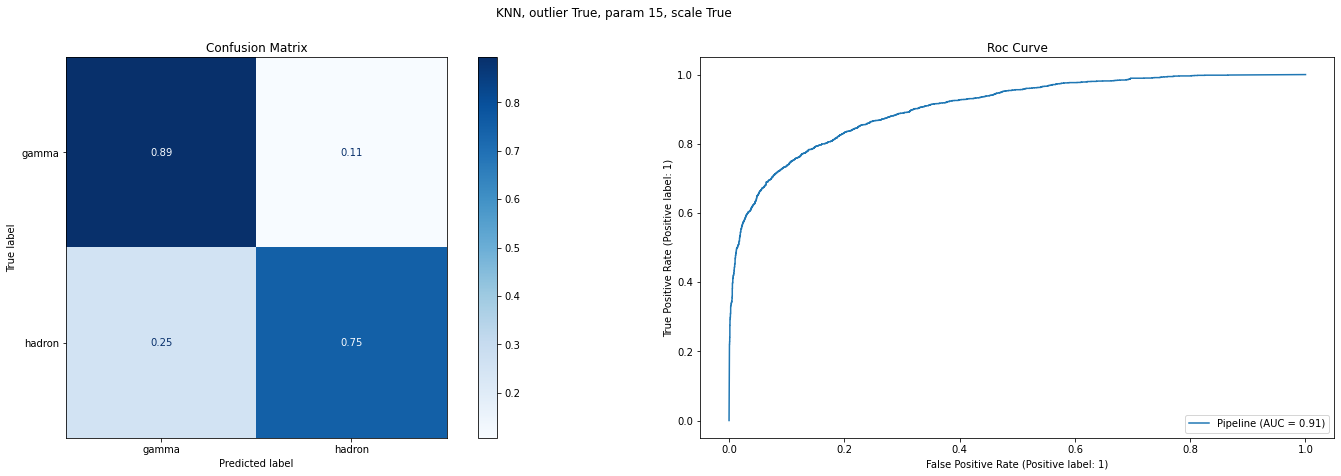


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 20, scale True = 0.7582353506732584
best parameter KNN, outlier True, param 20, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



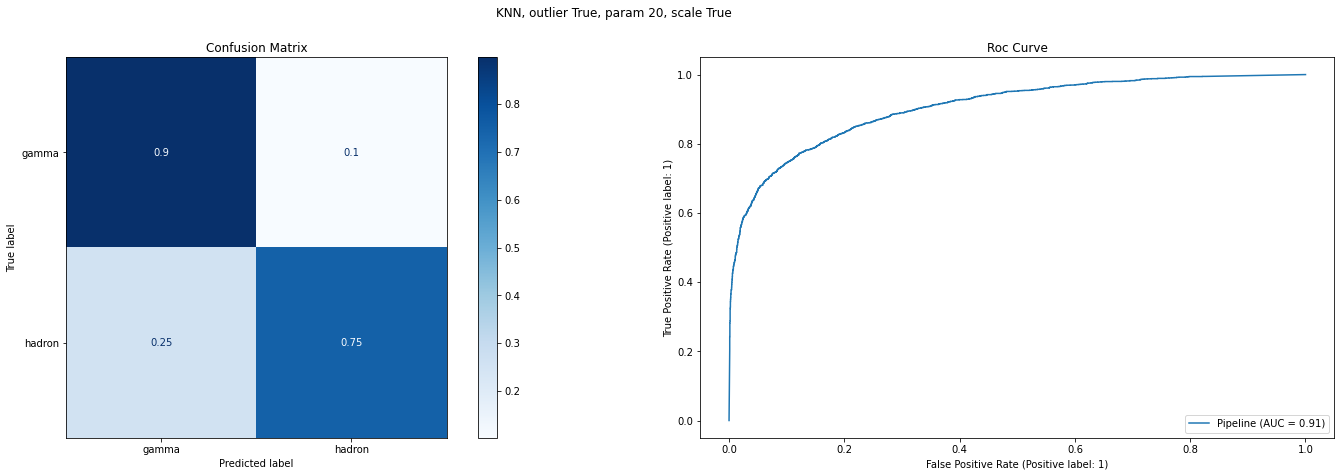


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 30, scale True = 0.7582177043529157
best parameter KNN, outlier True, param 30, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



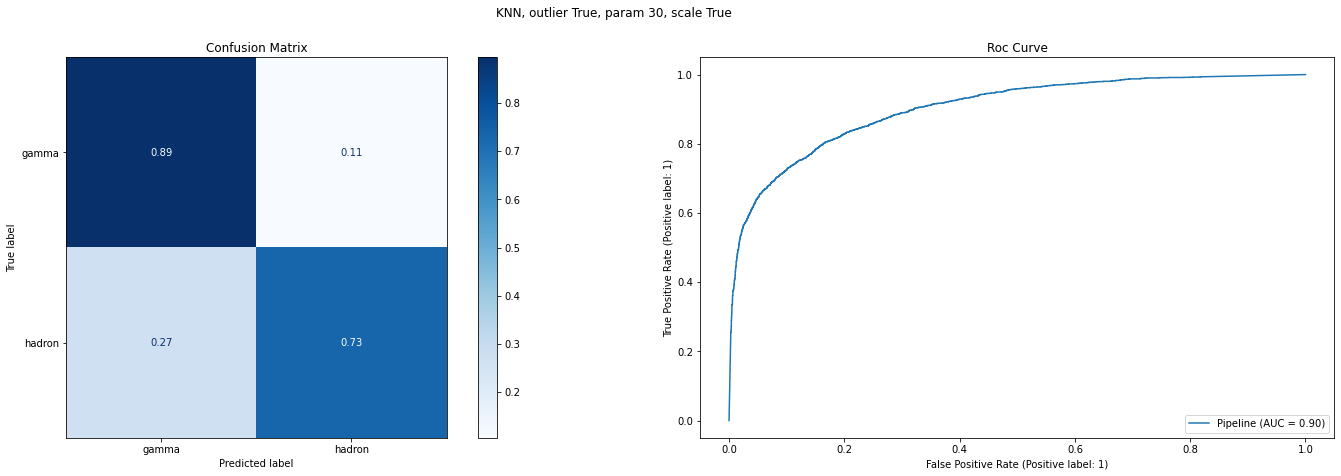


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier False, scale True = 0.7610922348452592
best parameter KNN, outlier False, scale True = {'classifier__weights': 'distance', 'classifier__n_neighbors': 38}



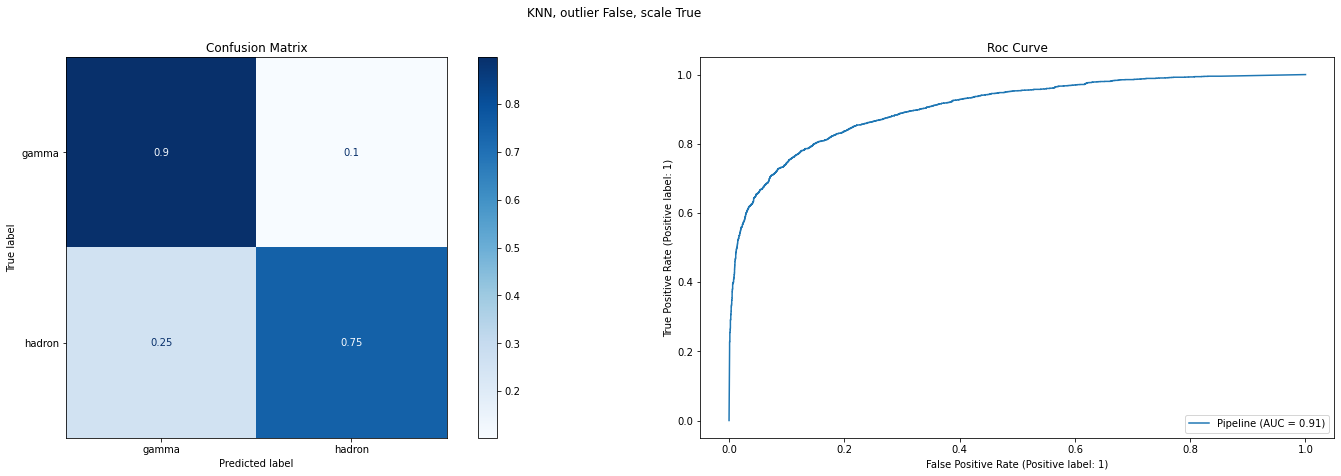

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 2, scale False = 0.7077066643338547
best parameter KNN, outlier True, param 2, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 38}



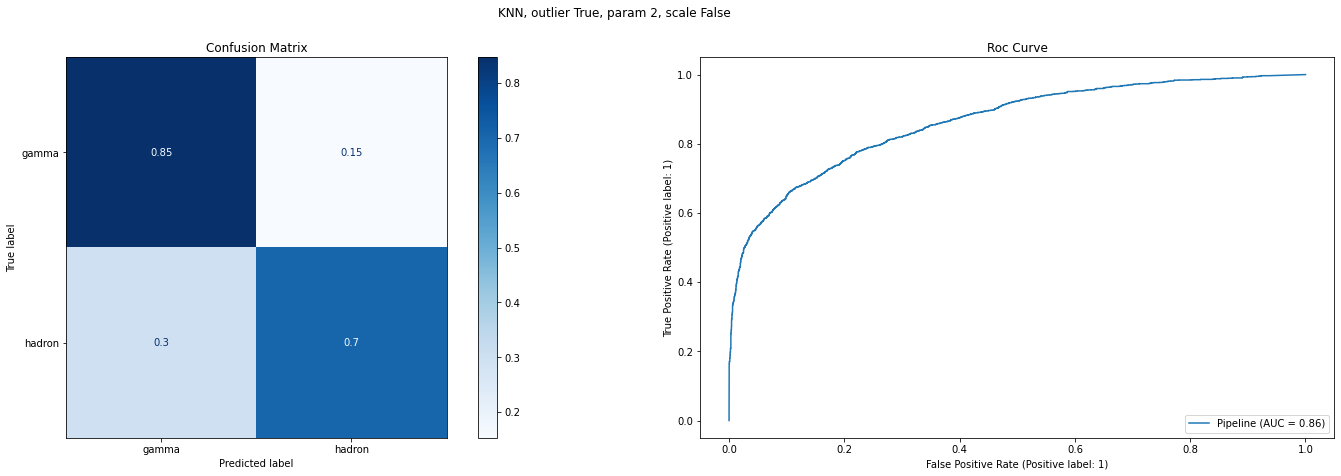


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 3, scale False = 0.7082940313307549
best parameter KNN, outlier True, param 3, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 50}



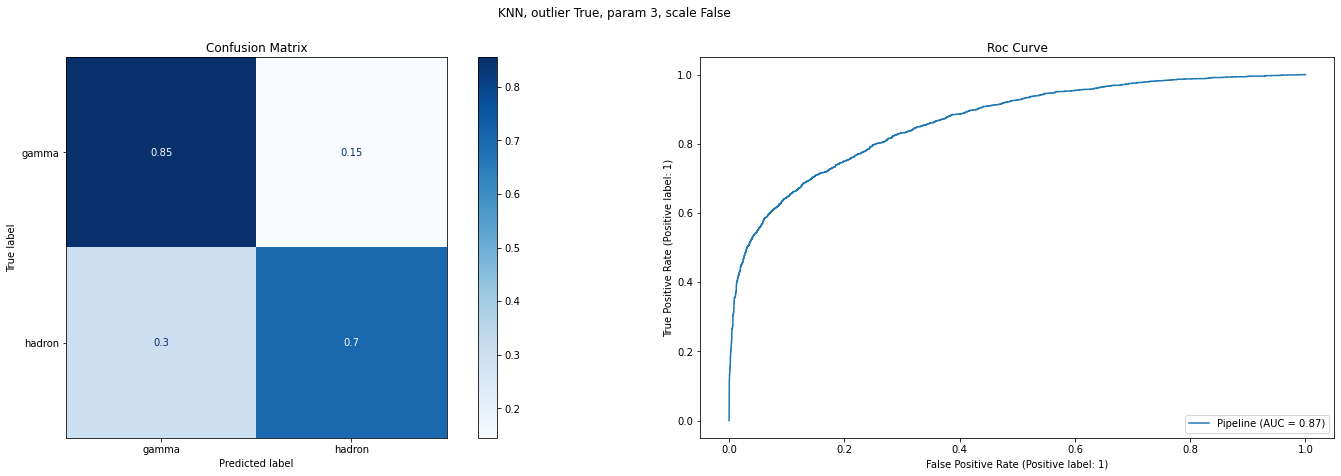


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 5, scale False = 0.7135088527814084
best parameter KNN, outlier True, param 5, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



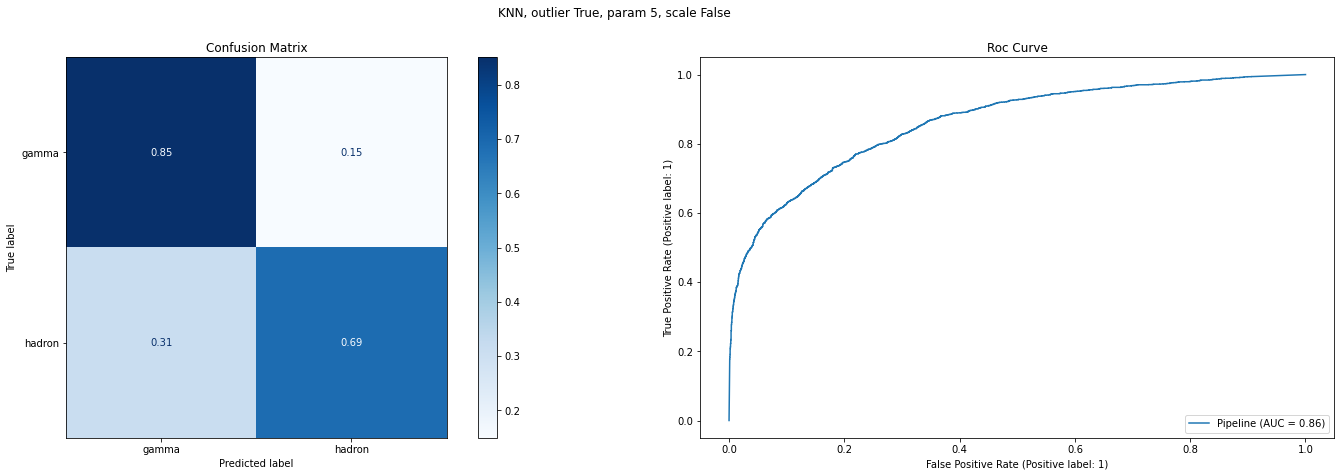


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 10, scale False = 0.7067262197041579
best parameter KNN, outlier True, param 10, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 38}



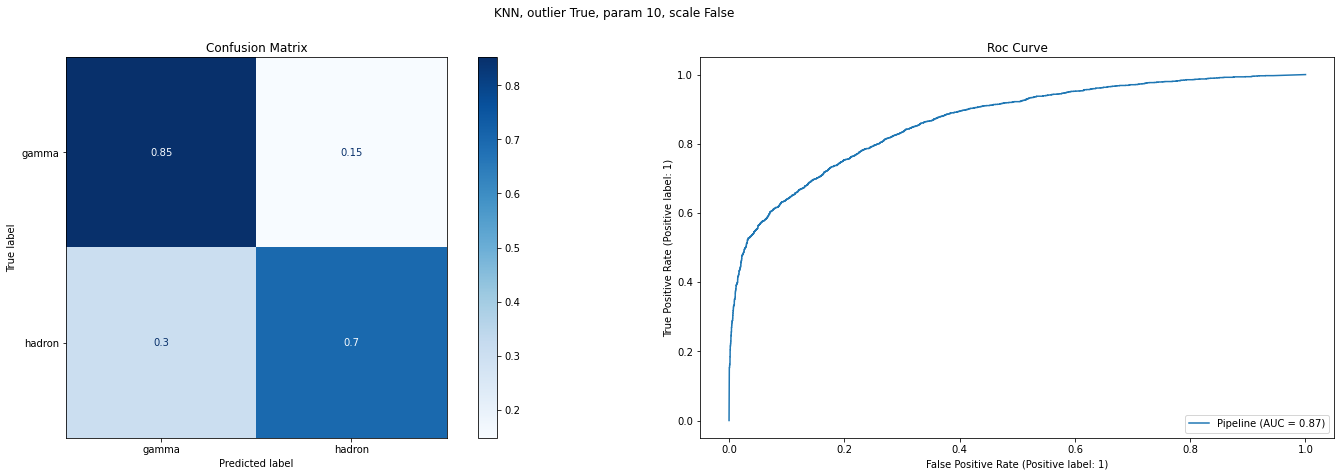


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 15, scale False = 0.7004405054968026
best parameter KNN, outlier True, param 15, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 35}



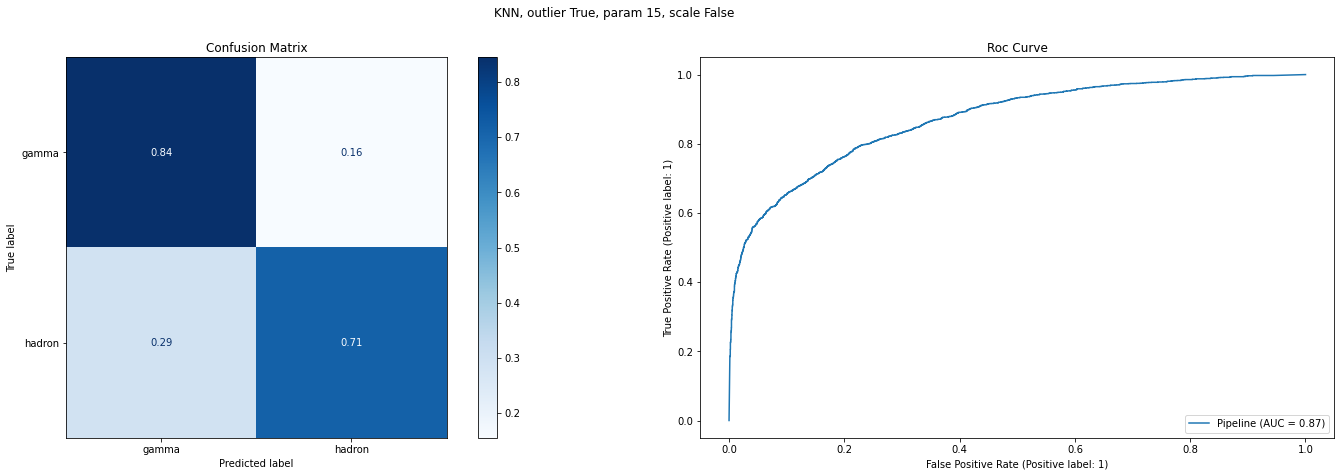


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 20, scale False = 0.7055541309203309
best parameter KNN, outlier True, param 20, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 30}



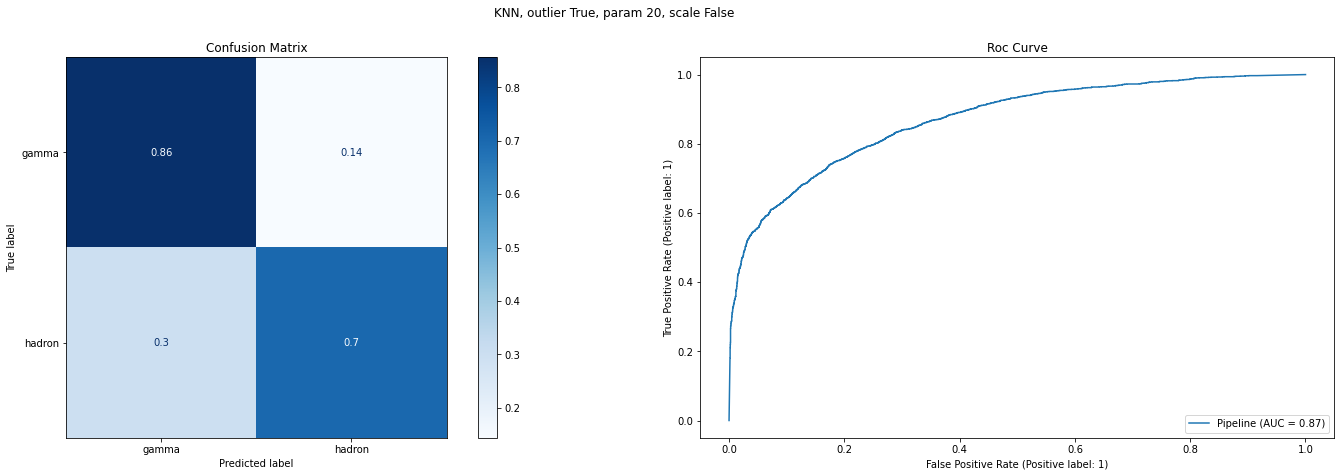


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier True, param 30, scale False = 0.7079727837922952
best parameter KNN, outlier True, param 30, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 38}



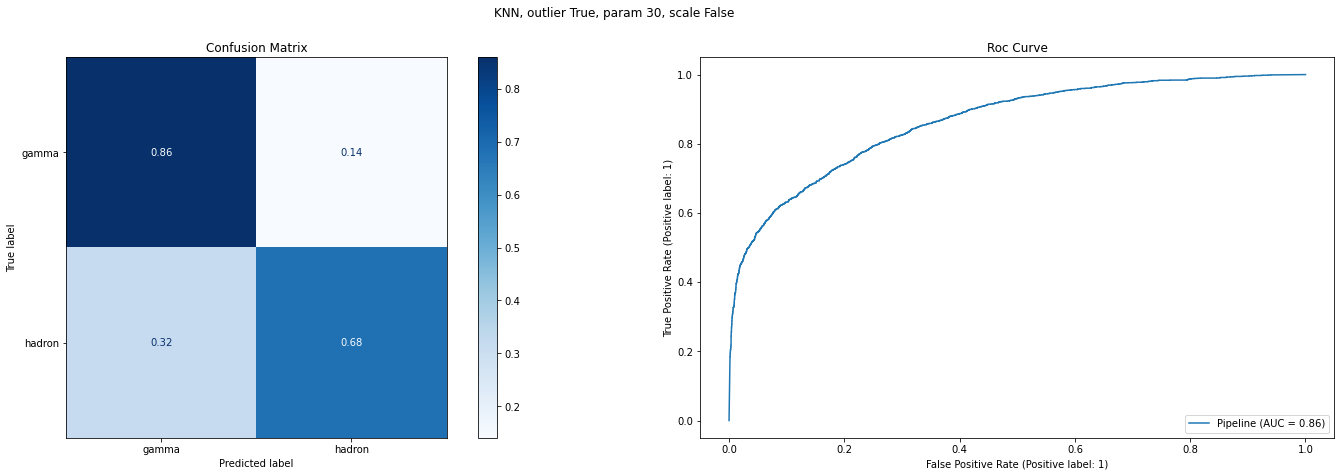


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


C:\Users\simop\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best Score KNN, outlier False, scale False = 0.6995999497839085
best parameter KNN, outlier False, scale False = {'classifier__weights': 'distance', 'classifier__n_neighbors': 50}



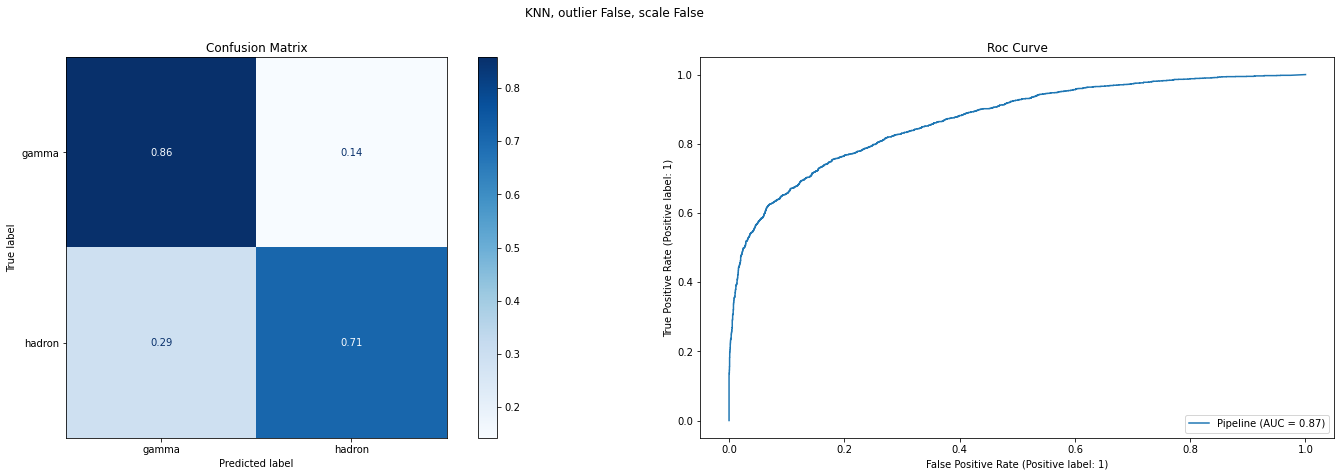

In [8]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, algorithm = 'auto', n_jobs=-1)
param_knn = {
                'classifier__n_neighbors': [ 35,38,30,50  ],
                'classifier__weights': ['uniform', 'distance']
                }


outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'KNN, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, neigh, title, param_knn, skf, 'SMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'KNN, outlier {o}, scale {s}'
            evaluate_model(X, y, neigh, title, param_knn, skf, 'SMOTE')

# SVM Gaussian kernel BorderlineSMOTE




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score SVM, outlier True, param 2, scale True = 0.7918898008839867
best parameter SVM, outlier True, param 2, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 5, 'classifier__gamma': 'scale', 'classifier__C': 7}



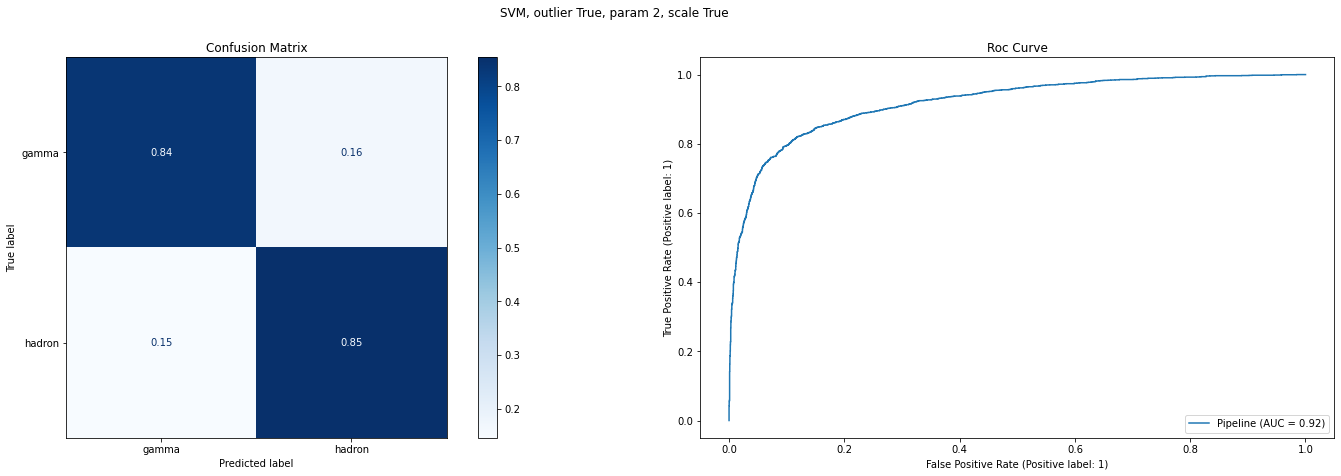


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score SVM, outlier True, param 3, scale True = 0.7887947015779645
best parameter SVM, outlier True, param 3, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 7, 'classifier__gamma': 'scale', 'classifier__C': 10}



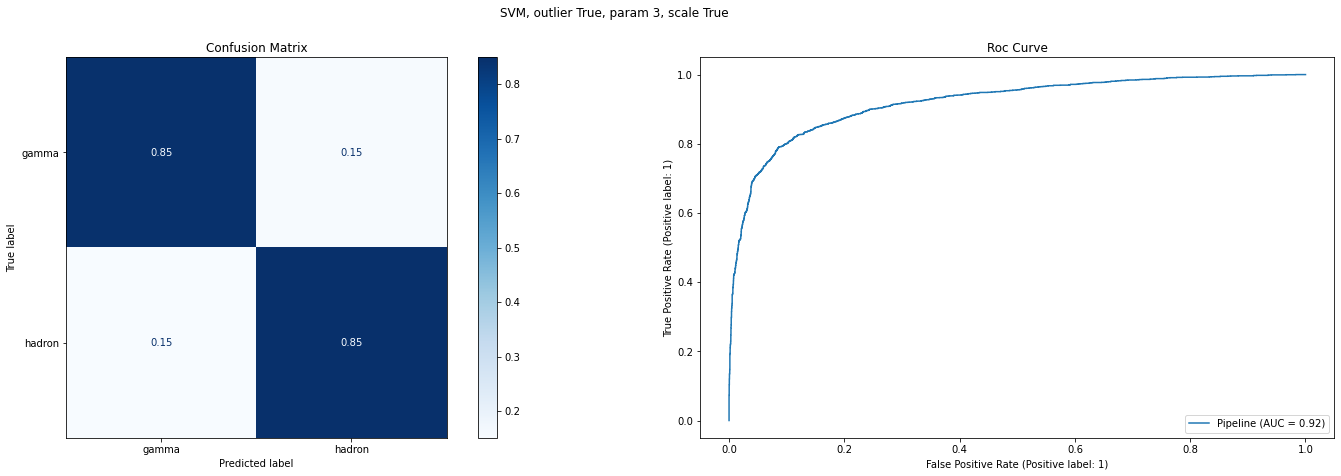


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score SVM, outlier True, param 5, scale True = 0.7907071670357664
best parameter SVM, outlier True, param 5, scale True = {'smote__sampling_strategy': 'minority', 'smote__k_neighbors': 8, 'classifier__gamma': 'scale', 'classifier__C': 10}



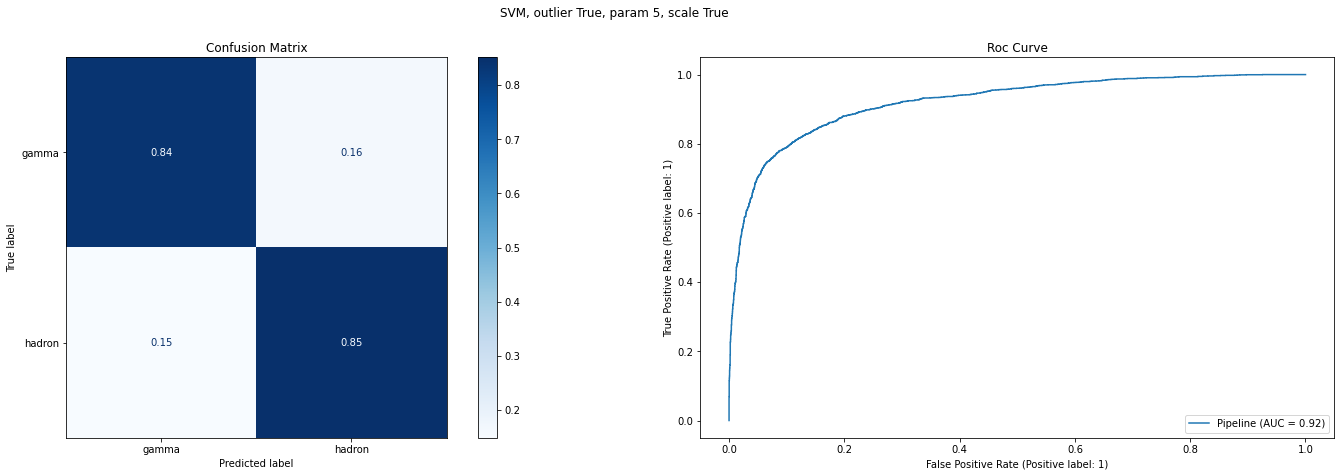


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score SVM, outlier True, param 10, scale True = 0.7889192292353312
best parameter SVM, outlier True, param 10, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 8, 'classifier__gamma': 'scale', 'classifier__C': 7}



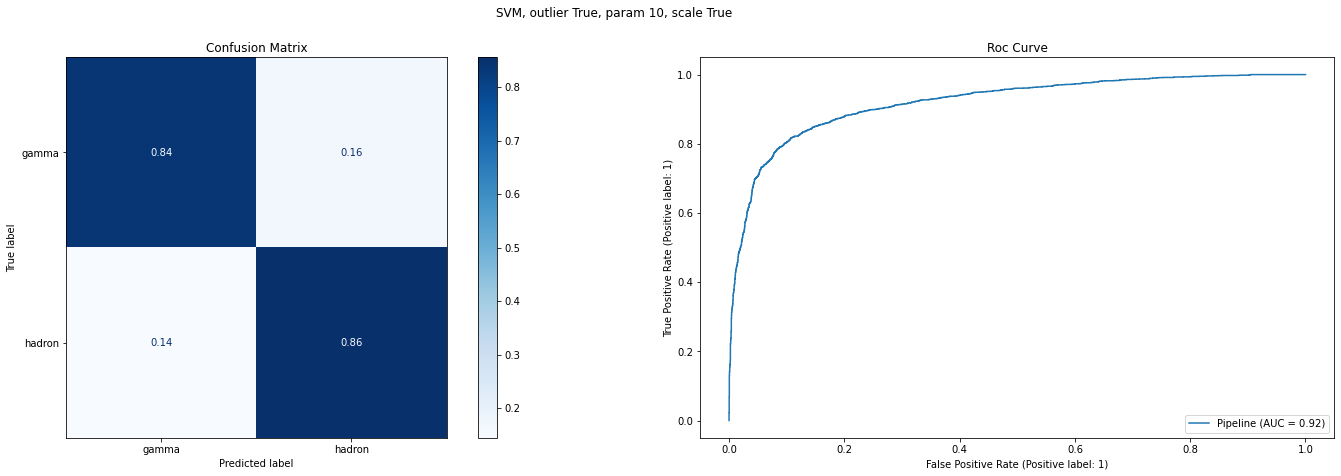


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
best Score SVM, outlier True, param 15, scale True = 0.7888923846605511
best parameter SVM, outlier True, param 15, scale True = {'smote__sampling_strategy': 'all', 'smote__k_neighbors': 7, 'classifier__gamma': 'auto', 'classifier__C': 10}



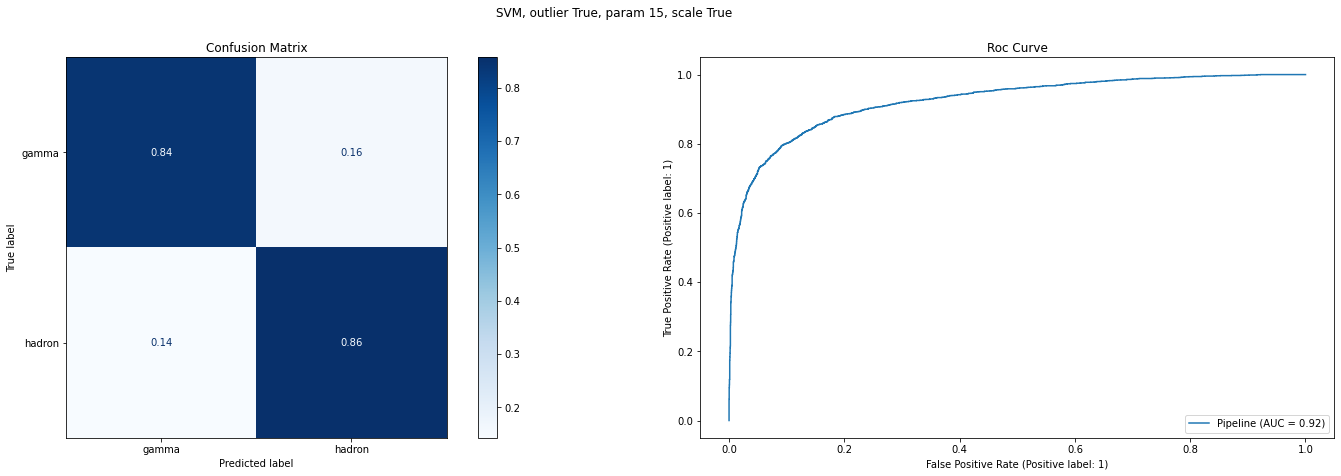


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [9]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 42 )  
param_svm = {   'smote__sampling_strategy':["minority", 'all'],
                'smote__k_neighbors': [5,7,8,10],
                'classifier__C'     : [.001, .01, .1,  1, 2, 5, 7, 10],
                'classifier__gamma' : ['auto', 'scale']  }

outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'SVM, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, svm, title, param_svm, skf, 'BorderlineSMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'SVM, outlier {o}, scale {s}'
            evaluate_model(X, y, svm, title, param_svm, skf, 'BorderlineSMOTE')

# SVM Gaussian Kernel SMOTE

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 42 )  
param_svm = {   'classifier__C'     : [.001, .01, .1,  1, 2, 5, 7, 10],
                'classifier__gamma' : ['auto', 'scale']  }

outlier = [True, False]
param_outlier = [2, 3, 5, 10, 15, 20, 30]
scale = [True, False]

for s in scale:
    for o in outlier:

        if o:
            for po in param_outlier:
            
                X_train, X_test, y_train, y_test, skf = prepare_data(df, o, po, s)
                
                X = (X_train, X_test)
                y = (y_train, y_test)
                
                title = f'SVM, outlier {o}, param {po}, scale {s}'
                evaluate_model(X, y, svm, title, param_svm, skf, 'SMOTE')
                print()
        else:
            X_train, X_test, y_train, y_test, skf = prepare_data(df, o, 'none', s)
                
            X = (X_train, X_test)
            y = (y_train, y_test)

            title = f'SVM, outlier {o}, scale {s}'
            evaluate_model(X, y, svm, title, param_svm, skf, 'SMOTE')